# Dynamical ephemeris investigations

Michele and Joe, March 2018

## Standard imports

In [1]:
import sys, os, re, math, functools, pickle

In [2]:
from IPython.display import HTML, display
import tabulate

In [3]:
import numpy as np

import scipy.optimize as so
import scipy.linalg as sla
import scipy.integrate as si
import scipy.interpolate as sin

import matplotlib.pyplot as pp

%matplotlib inline

## JPL ephemeris, masses

In [4]:
import ephem
from jplephem.spk import SPK
# import libstempo

In [12]:
bsp2 = SPK.open('bsp/de435t.bsp')

In [5]:
csec = 299792.458 # km/s

def getplanet(i,jdates,bsp=bsp):
    """Return a len(jdates) x 3 numpy array of the orbit for planet i,
    following the ephemeris file numbering (3 is Earth, 10 is Sun).
    Special cases: 310 is Sun to Earth, 399 is Earth bary + nutation,
    0 is again Sun."""
    
    if not isinstance(bsp,SPK):
        bsp = SPK.open('bsp/' + bsp)

    # get pos, vel in km, km/day
    if i == 399:
        pos, vel = bsp[0,3].compute_and_differentiate(jdates) + bsp[3,399].compute_and_differentiate(jdates)
    elif i == 310:
        pos, vel = bsp[0,3].compute_and_differentiate(jdates) - bsp[0,10].compute_and_differentiate(jdates)
    else:
        pos, vel = bsp[0,10 if i == 0 else i].compute_and_differentiate(jdates)
    
    # s, s/s
    return pos.T / csec, vel.T / csec / 86400

NameError: name 'bsp' is not defined

Standard set of dates: 60 years from Jan 1, 1960

In [ ]:
# jdates = np.linspace(ephem.julian_date('2000/1/1'),ephem.julian_date('2020/12/31'),2000)
jdates = np.linspace(ephem.julian_date('1960/1/1'),ephem.julian_date('2020/12/31'),2000)
dates  = jdates - 2400000.5

Ecliptic to equatorial roundtrip

In [ ]:
e_ecl = 23.43704 * math.pi / 180
M_ecl = np.array([[1,0,0],
                  [0,math.cos(e_ecl),-math.sin(e_ecl)],
                  [0,math.sin(e_ecl), math.cos(e_ecl)]])

def ecl2eq_vec(x):
    """Rotate (n,3) vector time series from ecliptic to equatorial."""
    return np.einsum('jk,ik->ij',M_ecl,x)
    
def eq2ecl_vec(x):
    """Rotate (n,3) vector time series from equatorial to ecliptic."""
    return np.einsum('kj,ik->ij',M_ecl,x)

### IAU standard masses and uncertainties

From http://maia.usno.navy.mil/NSFA/NSFA_cbe.html

|planet | mass parameter | error  |
|-------|-------------------------|
|MS/MMe | 6.023657330e6 | 2.35e−1 |
|MS/MVe | 4.08523719e5  | 8e−3    |
|MS/MMa | 3.09870359e6  | 2e−2    |
|       |               |         |
|MS/MJ  | 1.047348644e3 | 1.7e-5  |
|MS/MSa | 3.4979018e3   | 1e-4    |
|MS/MU  | 2.2902951e4   | 1.7e-2  |
|MS/MN  | 1.941226e4    | 3e-2    |
|    |                            |
|GMS | 1.32712442099e20 m3s−2 [TCB-compatible] | 1.0e10 m3s−2 |
|GMS | 1.32712440041e20 m3s−2 [TDB-compatible] | |
|    |                                         | |
|GME | 3.986004418e14 m3s−2 [TCB-compatible] | 8e5 m3s−2 |
|GME | 3.986004415e14 m3s−2 [TT-compatible]  |           |
|GME | 3.986004356e14 m3s−2 [TDB-compatible] |           |

In [ ]:
# in Msun
masses = 1.0 / np.array([1.0,
                         6.023657330e6,4.08523719e5,1.0,3.09870359e6,
                         1.047348644e3,3.4979018e3,2.2902951e4,1.941226e4])

GME = 3.986004418e14
GMS = 1.32712442099e20 # m3s−2

csecm = 299792458 # km/s
GMSs = GMS / csecm**3

# Earth mass
masses[3] = GME/GMS

In [17]:
masses

array([1.00000000e+00, 1.66012099e-07, 2.44783829e-06, 3.00348962e-06,
       3.22715604e-07, 9.54791898e-04, 2.85885670e-04, 4.36624957e-05,
       5.15138371e-05])

mass errors in Msun units: `dMplanet_over_Msun = dMsun_over_Mplanet / Msun_over_Mplanet**2`

In [ ]:
dmasses = np.array([1.0,2.35e-1,8e-3,1.0,2e-2,1.7e-5,1e-4,1.7e-2,3e-2]) * masses**2

dmasses[0] = 1.0e10 / GMS
dmasses[3] = 8e5 / GMS

In [19]:
dmasses

array([7.53508853e-11, 6.47660404e-15, 4.79352982e-14, 6.02807082e-15,
       2.08290722e-15, 1.54976687e-11, 8.17306164e-12, 3.24090301e-11,
       7.96102625e-11])

## Solar-system simulator

In [ ]:
def forces(t,vec,masses):
    # assume vector contains Sun + each planet pos[3]/vel[3] in sequence
    
    nplanets = int(len(vec)/6)
    ret = np.zeros_like(vec)
    
    for i in range(nplanets):
        ret[i*6:i*6+3] = vec[i*6+3:i*6+6]
        
        for j in range(nplanets):
            if i == j:
                continue
            
            d = vec[j*6:j*6+3] - vec[i*6:i*6+3] 
            r3 = np.dot(d,d)**1.5
            
            ret[i*6+3:i*6+6] += GMSs * masses[j] * d / r3
    
    return ret

Much faster, if not as pretty. Optimized (looking at `%%cython -a` output) to eliminate all Python operations within the loop.

In [ ]:
%load_ext Cython

In [ ]:
%%cython

import numpy as np

cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.cdivision(True)
def cforces(double t,np.ndarray[double,ndim=1] vec,np.ndarray[double,ndim=1] masses):
    # assume vector contains Sun + each planet pos[3]/vel[3] in sequence
    
    cdef int nplanets = vec.shape[0]//6
    cdef int i, j, k
    cdef double r3, norm
    
    cdef np.ndarray[double,ndim=1] d = np.zeros(3,'d')
    cdef np.ndarray[double,ndim=1] ret = np.zeros_like(vec)
    
    cdef double GMSs = 4.925491025543576e-06
    
    if masses.shape[0] > 9:
        GMSs = masses[9]

    cdef double dmsun = 0.0

    if masses.shape[0] > 10:
        dmsun = masses[10]
        
    for i in range(nplanets):
        ret[i*6] = vec[i*6+3]
        ret[i*6+1] = vec[i*6+4]
        ret[i*6+2] = vec[i*6+5]
        
        for j in range(nplanets):
            if i == j or masses[j] == 0.0:
                continue

            d[0] = vec[j*6] - vec[i*6] 
            d[1] = vec[j*6+1] - vec[i*6+1] 
            d[2] = vec[j*6+2] - vec[i*6+2] 
            
            r3 = (d[0]*d[0] + d[1]*d[1] + d[2]*d[2])**1.5
            
            if j == 0:
                norm = GMSs * (masses[0] + t * dmsun) / r3
            else:
                norm = GMSs * masses[j] / r3
            
            ret[i*6+3] += norm * d[0]
            ret[i*6+4] += norm * d[1]
            ret[i*6+5] += norm * d[2]
    
    return ret

Initial conditions from DE436. We use three sets of times:

* `jdates` - Julian dates (12h January 1, 4713 BC), used in ephemeris
* `dates  = jdates - 2400000.5` - modified Julian dates (0h Nov 17, 1858), used in nanograv
* `ts = (jdates - jdates[0])*86400` - seconds since 1960/01/01 0h

Our standard date range for integration:

* `jdates`: 1960/01/01 0h to 2020/12/31 0h

Our standard date range for export:

* (2020/12/31 0h - 20 standard years) to 2020/12/31 0h

From wikipedia:

**Julian day** (JD) is the continuous count of days since the beginning of the Julian Period, with Julian day number 0 assigned to the day starting at noon on Monday, January 1, 4713 BC, proleptic Julian calendar (November 24, 4714 BC, in the proleptic Gregorian calendar), a date at which three multi-year cycles started (which are: Indiction, Solar, and Lunar cycles) and which preceded any dates in recorded history.

The **Modified Julian Date** (MJD) was introduced by the Smithsonian Astrophysical Observatory in 1957 to record the orbit of Sputnik via an IBM 704 (36-bit machine) and using only 18 bits until August 7, 2576. MJD is the epoch of VAX/VMS and its successor OpenVMS, using 63-bit date/time, which allows times to be stored up to July 31, 31086, 02:48:05.47. The MJD has a starting point of midnight on November 17, 1858 and is computed by MJD = JD - 2400000.5

In [ ]:
ts = (jdates - jdates[0])*86400
t0, t1 = 0, ts[-1]

def gety0(bsp=bsp):
    ret = []

    for p in range(9):
        pos, vel = getplanet(10 if p == 0 else p,jdates[0],bsp=bsp)
        ret.append(pos)
        ret.append(vel)
    
    return np.hstack(ret)

y0 = gety0()

Currently using the legacy `ode` interface, with a `set_solout` callback to capture intermediate integration steps.


    "dopri5" is an explicit runge-kutta method of order (4)5 due to Dormand &
    Prince (with stepsize control and dense output).

    Authors:

        E. Hairer and G. Wanner
        Universite de Geneve, Dept. de Mathematiques
        CH-1211 Geneve 24, Switzerland
        e-mail:  ernst.hairer@math.unige.ch, gerhard.wanner@math.unige.ch

    This code is described in [HNW93]_.

    This integrator accepts the following parameters in set_integrator()
    method of the ode class:

    - atol : float or sequence
      absolute tolerance for solution
    - rtol : float or sequence
      relative tolerance for solution
    - nsteps : int
      Maximum number of (internally defined) steps allowed during one
      call to the solver.
    - first_step : float
    - max_step : float
    - safety : float
      Safety factor on new step selection (default 0.9)
    - ifactor : float
    - dfactor : float
      Maximum factor to increase/decrease step size by in one step
    - beta : float
      Beta parameter for stabilised step size control.
    - verbosity : int
      Switch for printing messages (< 0 for no messages).

In [ ]:
def integrate(y0,masses):
    backend = 'dopri5' # 'dop853'
    solver = si.ode(cforces).set_integrator(backend,nsteps=100000,atol=1e-10,rtol=1e-10)

    sol = []
    def solout(t, y):
        sol.append([t, *y])

    solver.set_solout(solout)
    solver.set_initial_value(y0, t0).set_f_params(masses)
    solver.integrate(t1)

    return np.array(sol)

Extract integration times and single-planet solutions

In [ ]:
def t(sol):
    return sol[:,0]

def sel(sol,p):
    # works also on initial conditions, in which case there's not time column
    return sol[p*6:p*6+6] if sol.ndim == 1 else sol[:,p*6+1:p*6+7]

def isel(sol,p,ts):
    return sin.interp1d(t(sol),sel(sol,p)[:,0],kind='cubic')(ts)

In [22]:
%%time
sol = integrate(y0,masses)

CPU times: user 2.45 s, sys: 194 ms, total: 2.64 s
Wall time: 2.51 s


## Center-of-mass correction

Center of mass position and velocity

In [ ]:
def cmass(sol,masses):
    cm = masses[0]*sel(sol,0)
    
    for i in range(1,9):
        cm += masses[i]*sel(sol,i)
    
    cm /= np.sum(masses)
    
    return cm

Our solution shows some drift

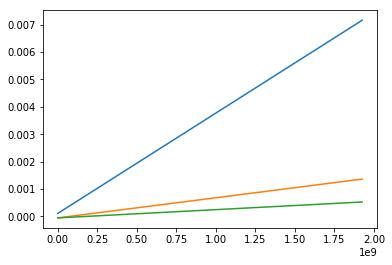

In [24]:
cm = cmass(sol,masses)

for i in range(3):
    pp.plot(t(sol),cm[:,i])

Let's correct the drift before integrating

In [ ]:
def cintegrate(y0, masses, init=False):
    cm = cmass(y0, masses)
    
    y0cm = y0.copy()
    for i in range(9):
        y0cm[i*6:(i+1)*6] -= cm[:]
    
    sol = integrate(y0cm, masses)
    
    return (sol, y0cm) if init else sol

In [ ]:
csol = cintegrate(y0,masses)

Way smaller!

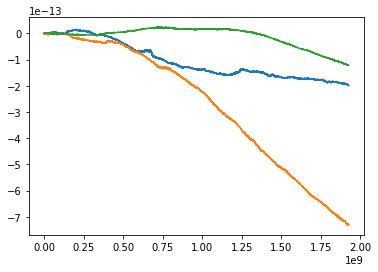

In [27]:
cm = cmass(csol,masses)

for i in range(3):
    pp.plot(t(csol),cm[:,i])

## Tests of integrator

Compare all planets (x-y plane) with DE436. Mercury may be a little funny (maybe a variational integrator is needed).

In [ ]:
planets = ['Sun','Mercury','Venus','Earth','Mars','Jupiter','Saturn','Uranus','Neptune']

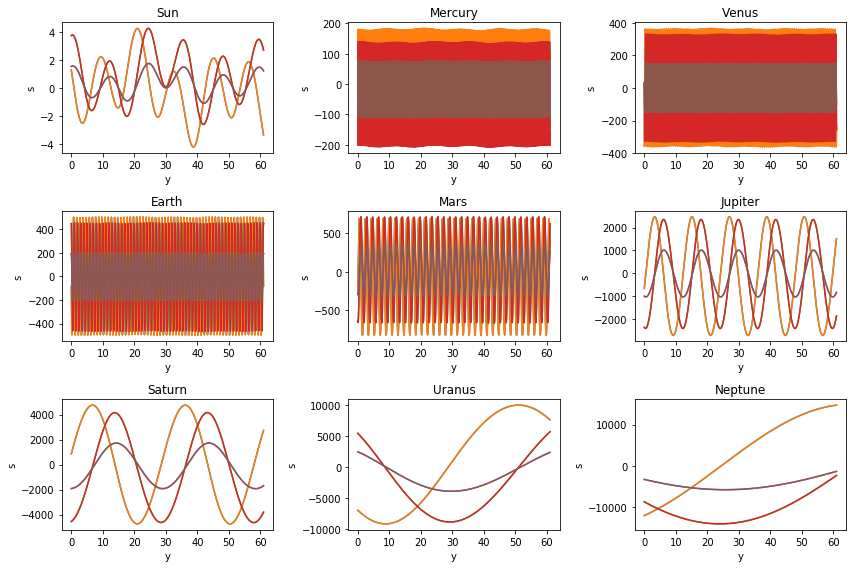

In [51]:
pp.figure(figsize=(12,8))

for p in range(9):
    pp.subplot(3,3,p+1)

    pl, vpl = getplanet(p,jdates)
    sl = sel(csol,p)
    
    for i in range(3):
        pp.plot((jdates - jdates[0])/365.25,pl[:,i])
        pp.plot(t(csol)/86400/365.25,sl[:,i])
    
    pp.xlabel('y'); pp.ylabel('s')
    pp.title(planets[p])
    
pp.tight_layout()

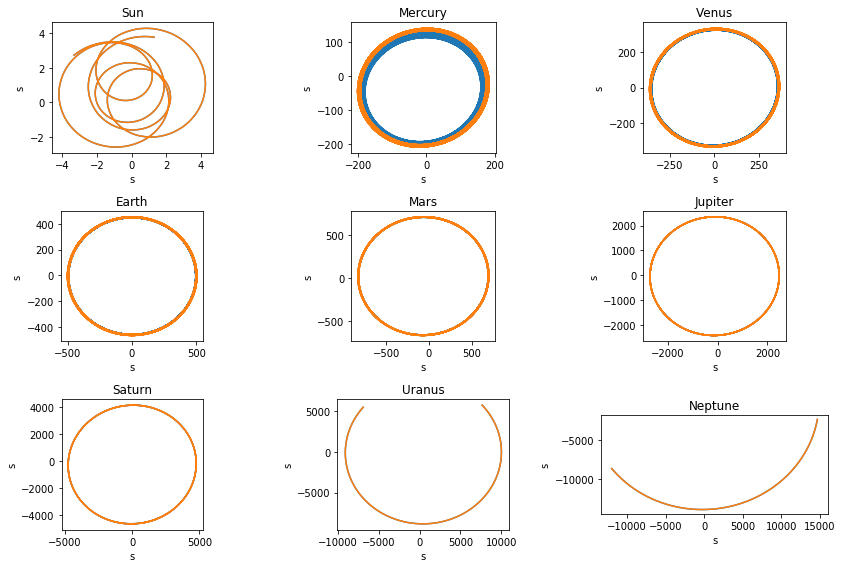

In [52]:
pp.figure(figsize=(12,8))

for p in range(9):
    pp.subplot(3,3,p+1,aspect='equal')

    pl, vpl = getplanet(p,jdates)
    sl = sel(csol,p)
    
    pp.plot(pl[:,0],pl[:,1])
    pp.plot(sl[:,0],sl[:,1])
    
    pp.xlabel('s'); pp.ylabel('s')
    pp.title(planets[p])
    
pp.tight_layout()

Note Sun difference at 100 us

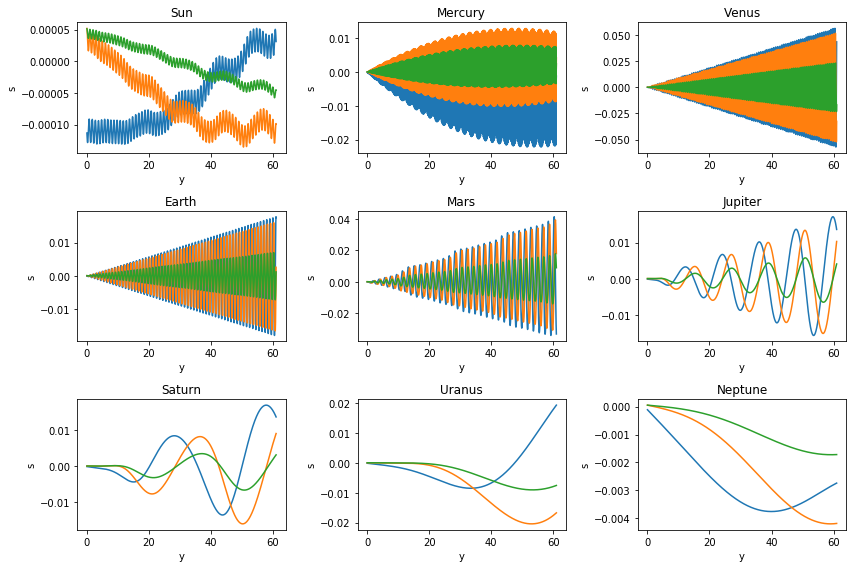

In [53]:
pp.figure(figsize=(12,8))

for p in range(9):
    pp.subplot(3,3,p+1)

    pos, vel = getplanet(p,jdates)
    tsol, jpos = t(csol), sel(csol,p)
    
    for i in range(3):
        pp.plot(ts/86400/365.25,
                sin.interp1d(tsol,jpos[:,i],kind='cubic')(ts) - pos[:,i])
    
    pp.xlabel('y'); pp.ylabel('s')
    pp.title(planets[p])
    
pp.tight_layout()

## Mass perturbations

In [ ]:
# mass perturbation

def dm(i,d):
    ret = np.zeros(9,'d')
    ret[i] = d
    return ret

In [ ]:
# Project out linear and quadratic

def project(x,y,degree=2):
    if degree is None:
        return x, None, y
    
    cs = np.polyfit(x,y,degree)
    ym = sum(c * x**(degree-i) for i,c in enumerate(cs))
    
    return x, ym, y-ym

Compare the nonlinear partial with the SSB "mass projection". Essentially equivalent for everybody out to Jupiter.

In [ ]:
def dmass_analysis(planet):
    csol1 = cintegrate(y0,masses + dm(planet,2*dmasses[planet]))
    dmass = 2*dmasses[planet] * sel(csol1,planet)
    
    pp.figure(figsize=(12,8))

    for i,p in enumerate(range(9),1):
        pp.subplot(3,3,i)

        for i in range(3):
            pp.plot(t(csol1) / 86400 / 365.25,
                    1e9*(sin.interp1d(t(csol),sel(csol,p)[:,i],kind='cubic')(t(csol1)) - sel(csol1,p)[:,i]))

            pp.plot(t(csol1) / 86400 / 365.25,
                    1e9 * dmass[:,i], ':')
        
        pp.xlabel('y'); pp.ylabel('ns')
        pp.title(planets[p])

    pp.suptitle(planets[planet] + " mass perturbation (2 IAU sigma)", fontsize=14)
    pp.tight_layout(rect=[0,0,1,0.95]) # save 5% of vertical space for title
    
    pp.figure(figsize=(6,3.5))
    
    p = 0 # look at Sun

    ts = t(csol1) / 86400 
    ind = np.where(ts > ts[-1] - 20 * 365.25)[0][0] # fit only the last 20 years

    for i in range(3):
        dx = 1e9 * dmass[:,i]
        x, y, ym = project(ts[ind:],dx[ind:])
        pp.plot(x/365.25,ym,':')

        dx = 1e9*(sin.interp1d(t(csol),sel(csol,p)[:,i],kind='cubic')(t(csol1)) - sel(csol1,p)[:,i])
        x, y, ym = project(ts[ind:],dx[ind:])
        pp.plot(x/365.25,ym)
        
    pp.xlabel('y'); pp.ylabel('ns')
    pp.title("Sun after projection")

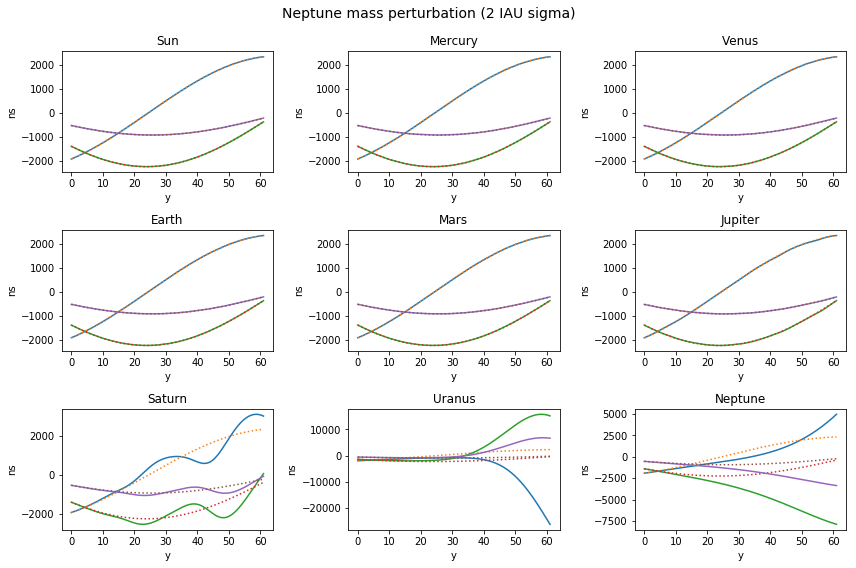

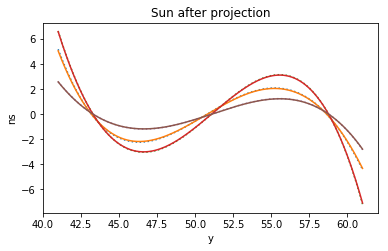

In [35]:
dmass_analysis(8)

Curious that Mercury seems to freak out a little...

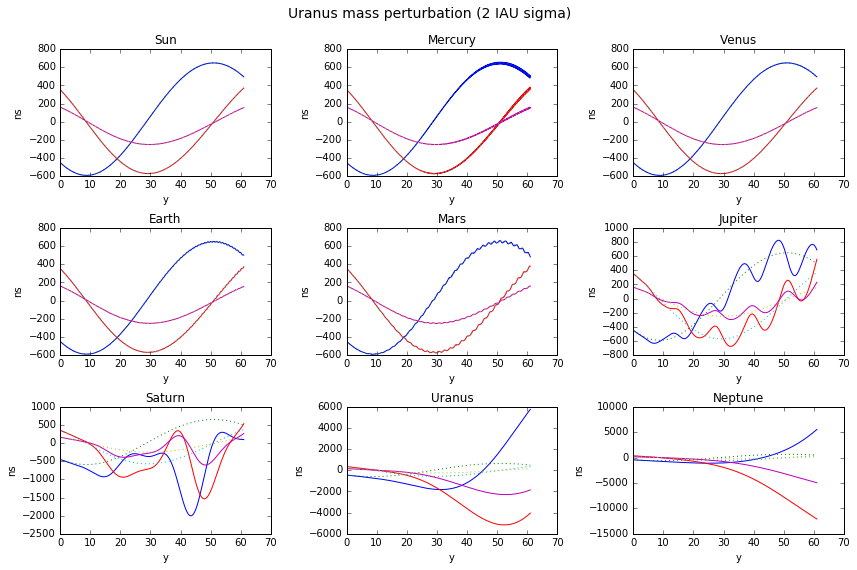

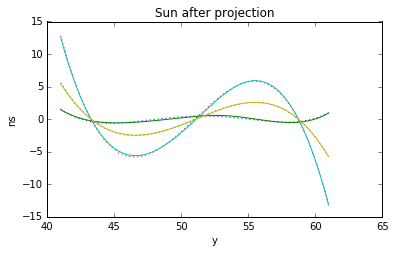

In [33]:
dmass_analysis(7)

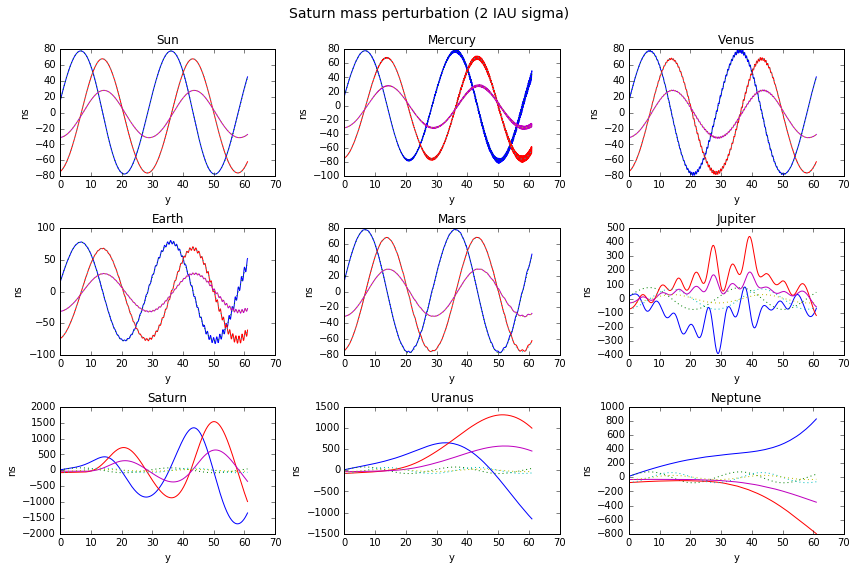

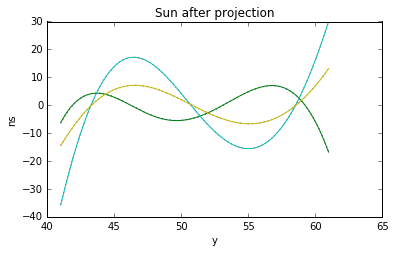

In [34]:
dmass_analysis(6)

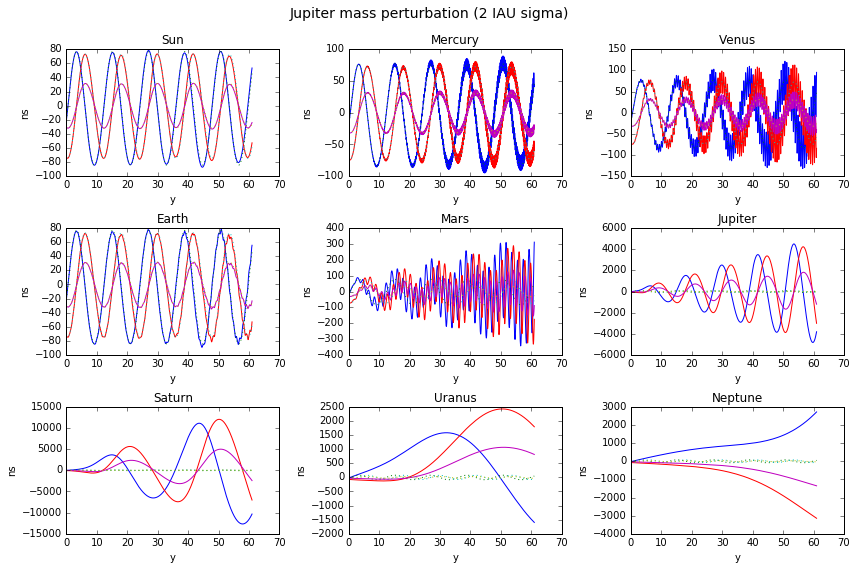

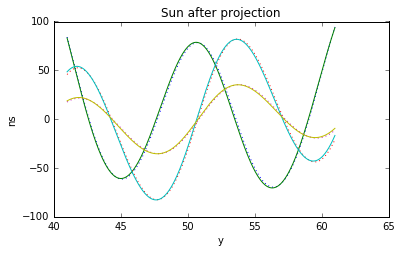

In [35]:
dmass_analysis(5)

## Can we reproduce JPL DE differences with our integrator? To some extent.

**TLDR: (DE436 - DE435) is explained by Jupiter initial conditions; (DE436 - DE430) by Uranus mass and Jupiter initial conditions, although there's a residual at the 50 ns level; (DE436 - DE420) by Uranus and Neptune mass, Sun/Jupiter initial conditions, with residual at the 50 ns level.**

We must be limited by physics (or bodies) we do not have, since actual orbits are only recovered at 50 us for Sun, 0.1 s for Jupiter.

### DE436 vs DE435

In [36]:
# GMS430 / 5794556.4 * 1e-9 = 22902.95078359051 (updated Uranus)

In [ ]:
masses436 = 1.0/np.array([1.0,
                          6.023682155592e6,
                          4.08523718658e5,
                          1.0,
                          3.098703590291e6,
                          1.047348625e3,
                          3.497901768e3,
                          22902.95078359051, # 2.2902981613e4,
                          1.9412259776e4])

GMS430 = 1.32712440041939400e20
masses436[3] = 3.98600435436e14/GMS430

masses436 = np.concatenate((masses436,[GMS430 / csecm**3]))

First verify that we can reproduce the difference between DE435 and DE436 with our integration. Yes, with minor variations.

In [33]:
csol = cintegrate(gety0(bsp), masses436)

In [34]:
csol2 = cintegrate(gety0(bsp2), masses436)

Check overall DE436 and DE435 reproduction.

In [ ]:
def plotcomp(csol,bsp):
    pp.figure(figsize=(12,8))

    for p in range(9):
        pp.subplot(3,3,p+1)

        pos, vel = getplanet(p,jdates,bsp=bsp)
        tsol, jpos = t(csol), sel(csol,p)

        for i in range(3):
            pp.plot(ts/86400/365.25,
                    sin.interp1d(tsol,jpos[:,i],kind='cubic')(ts) - pos[:,i])

        pp.xlabel('y'); pp.ylabel('s')
        pp.title(planets[p])

    pp.tight_layout()

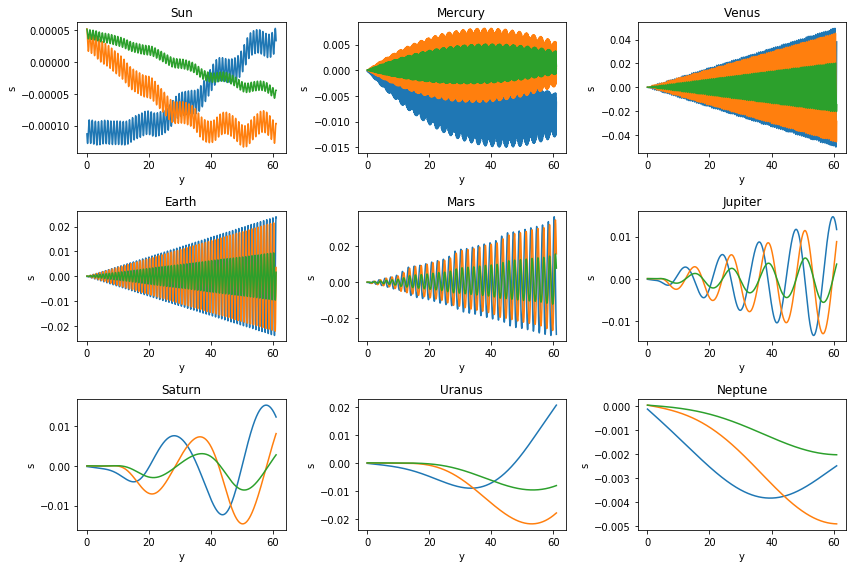

In [36]:
plotcomp(csol,bsp)

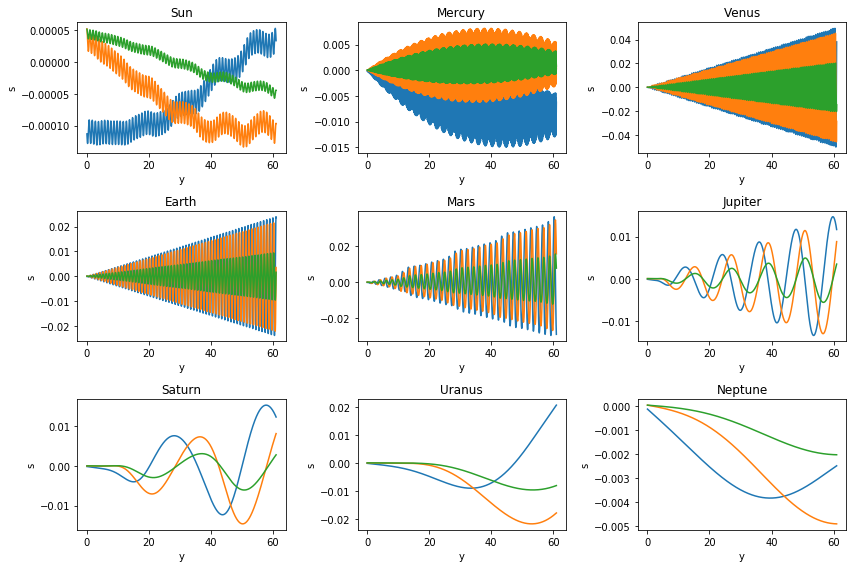

In [37]:
plotcomp(csol2,bsp2)

In [ ]:
def plotdiff(bsp,bsp2,csol,csol2,title,degree=0,plotdiff=False):
    p = 0 # look at Sun

    pos, vel = getplanet(0,jdates,bsp=bsp)
    pos2, vel2 = getplanet(0,jdates,bsp=bsp2)

    for i in range(3):
        x, ym, dy = project((jdates - jdates[0])/365.25,
                            1e9*(pos[:,i] - pos2[:,i]),
                            degree=degree)
        
        pp.plot(x,dy)

        x, ym, dy = project(t(csol2) / 86400 / 365.25,
                            1e9*(sin.interp1d(t(csol),sel(csol,p)[:,i],kind='cubic')(t(csol2)) - sel(csol2,p)[:,i]),
                            degree=degree)
        
        pp.plot(x,dy,'--')
            
    pp.xlabel('y'); pp.ylabel('ns')
    pp.title(title);
    
    if plotdiff:
        pp.figure()
        
        ts = jdates - jdates[0]
        ind = np.where(ts > ts[-1] - 20 * 365.25)[0][0] # fit only the last 20 years
 
        pos, vel = getplanet(0,jdates[ind:],bsp=bsp)
        pos2, vel2 = getplanet(0,jdates[ind:],bsp=bsp2)

        rms = 0
        for i in range(3):
            x = ts[ind:] * 86400
            y = 1e9*(pos[:,i] - pos2[:,i]) - 1e9*(sin.interp1d(t(csol),sel(csol,p)[:,i],kind='cubic')(x) -
                                                  sin.interp1d(t(csol2),sel(csol2,p)[:,i],kind='cubic')(x))

            x, ym, dy = project(ts[ind:]/365.25,y,degree=degree)
            pp.plot(x,dy)
            
            rms += np.var(dy)
        
        pp.title('Diff of diffs, last 20 years: rms = {:.0f} ns'.format(math.sqrt(rms)))
        pp.axis(xmax=62); pp.xlabel('y'); pp.ylabel('ns')

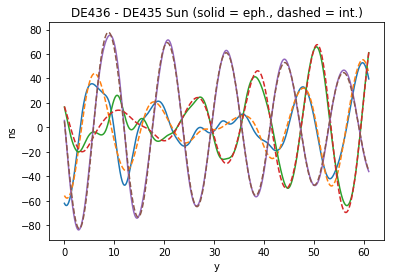

In [39]:
plotdiff(bsp, bsp2, csol, csol2, 'DE436 - DE435 Sun (solid = eph., dashed = int.)')

Next, see if it's sufficient to change Jupiter.

In [45]:
y0mod = gety0()
y0mod[6*5:6*5+6] = sel(gety0(bsp2), 5)

print(y0mod - y0)

csolmod = cintegrate(y0mod, masses436)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -6.03087187e-05   1.27142553e-05
   7.36406662e-06  -2.67783937e-13  -4.19288665e-13  -1.45411795e-12
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00]


It really looks like it is. Maybe we knew this though.

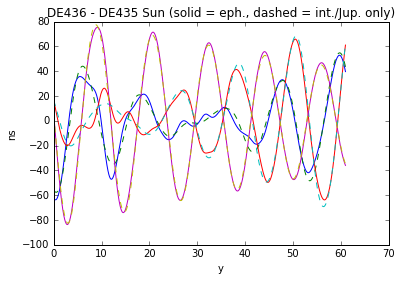

In [46]:
plotdiff(bsp, bsp2, csol, csolmod, 'DE436 - DE435 Sun (solid = eph., dashed = int./Jup. only)')

### DE436 vs DE430

In [ ]:
masses430 = 1.0/np.array([1.0,
                          6.023682155592e6,
                          4.08523718658e5,
                          1.0,
                          3.098703590291e6,
                          1.047348625e3,
                          3.497901768e3,
                          2.2902981613e4,
                          1.9412259776e4])

GMS430 = 1.32712440041939400e20
masses430[3] = 3.98600435436e14/GMS430

masses430 = np.concatenate((masses430,[GMS430 / csecm**3]))

Changing the mass of Uranus seems to capture a lot of the difference, even with DE436 initial conditions. The change is within the Uranus dmass. Maybe a rotation would help also, but let's just remove a DC + linear trend.

Change masses and init pos/vel.

In [48]:
csol3 = cintegrate(gety0('de430t.bsp'), masses430)

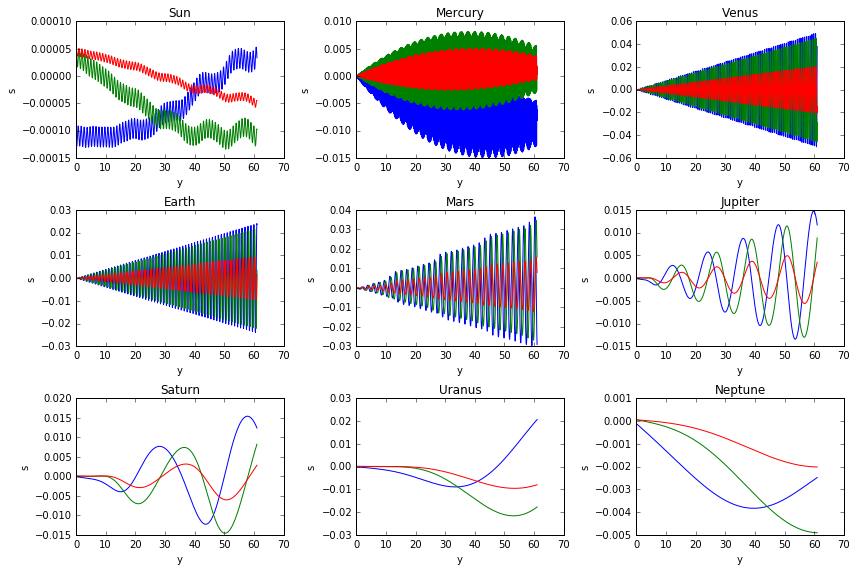

In [49]:
plotcomp(csol3,'de430t.bsp')

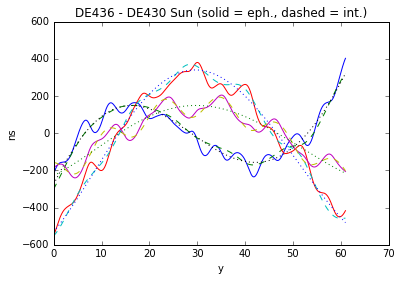

In [50]:
plotdiff(bsp, 'de430t.bsp', csol, csol3, 'DE436 - DE430 Sun (solid = eph., dashed = int.)', degree=1)

# dotted: Uranus mass projection
for i in range(3):
    x, y, dy = project(ts,-1e9*((masses436[7]-masses430[7])/sum(masses436))*getplanet(7,jdates,'de430t.bsp')[0][:,i],1)
    pp.plot(ts/86400/365.25,dy,':')

Change only Neptune mass, all pos/vel. Still pretty good.

In [51]:
masses430b = masses436.copy()
masses430b[7] = masses430[7]

csol3 = cintegrate(gety0('de430t.bsp'), masses430b)

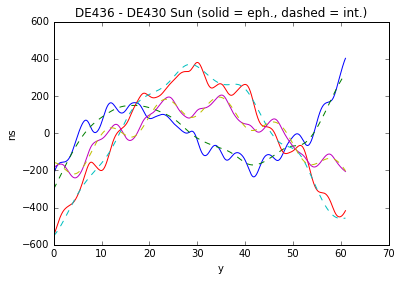

In [52]:
plotdiff(bsp, 'de430t.bsp', csol, csol3, 'DE436 - DE430 Sun (solid = eph., dashed = int.)', degree=1)

Change Neptune mass, none of the pos/vel. Misses some of the detail.

In [53]:
csol3 = cintegrate(gety0(), masses430b)

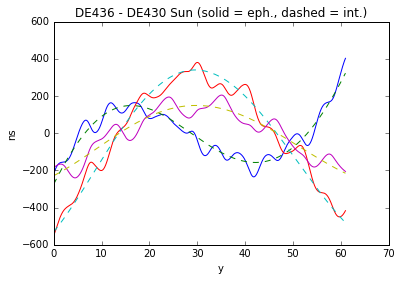

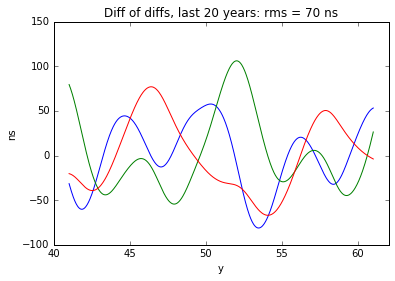

In [54]:
plotdiff(bsp, 'de430t.bsp', csol, csol3, 'DE436 - DE430 Sun (solid = eph., dashed = int.)', degree=1, plotdiff=True)

Bring back Jupiter to improve.

In [55]:
y0mod = gety0()

for p in [5]:
    y0mod[6*p:6*p+6] = sel(gety0('de430t.bsp'), p)

csol3 = cintegrate(y0mod, masses430b)

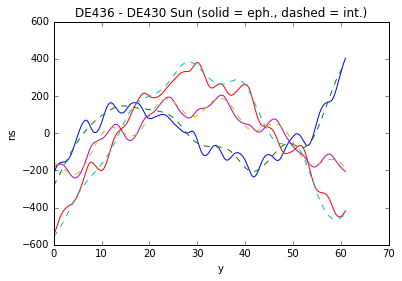

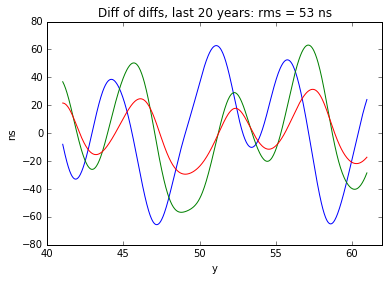

In [56]:
plotdiff(bsp, 'de430t.bsp', csol, csol3, 'DE436 - DE430 Sun (solid = eph., dashed = int.)', degree=1, plotdiff=True)

### DE436 vs DE421

In [ ]:
masses421 = 1.0/np.array([1.0,
                          6.023597400017e6,
                          4.08523718658e5,
                          1.0,
                          3.098703590291e6,
                          1.047348625e3,
                          3.497901768e3,
                          2.2902981613e4,
                          1.9412237346e4])

GMS421 = 1.32712440040944000e20
masses421[3] = 3.98600436233e14/GMS421 # ??? not in table, have to look at text

masses421 = np.concatenate((masses421,[GMS421 / csecm**3]))

In [58]:
csol4 = cintegrate(gety0('de421.bsp'), masses421)

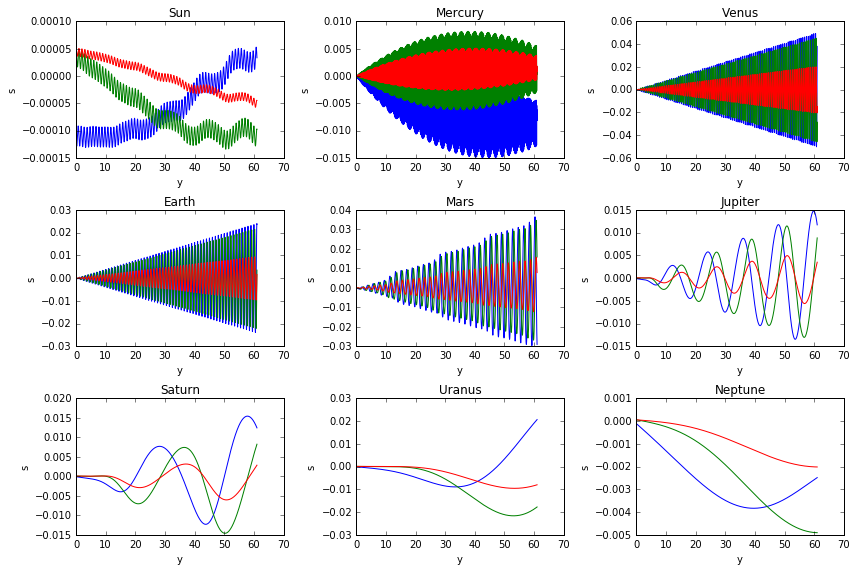

In [59]:
plotcomp(csol4,'de421.bsp')

Changes masses but not positions.

In [60]:
csol4 = cintegrate(gety0(), masses421)

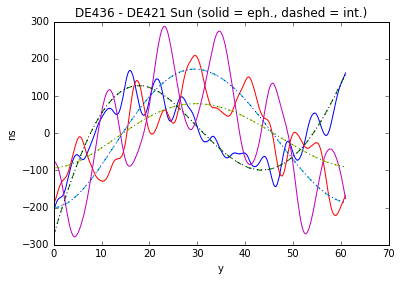

In [61]:
plotdiff(bsp, 'de421.bsp', csol, csol4, 'DE436 - DE421 Sun (solid = eph., dashed = int.)', degree=1)

# dotted: Uranus mass projection
for i in range(3):
    x, y, dy = project(ts,
                       -1e9*((masses436[7]-masses421[7])/sum(masses436))*getplanet(7,jdates,'de421.bsp')[0][:,i]
                       -1e9*((masses436[8]-masses421[8])/sum(masses436))*getplanet(8,jdates,'de421.bsp')[0][:,i]
                       ,1)
    pp.plot(ts/86400/365.25,dy,':')

Change masses and positions.

In [62]:
csol4 = cintegrate(gety0('de421.bsp'), masses421)

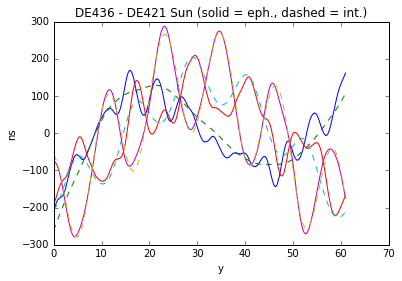

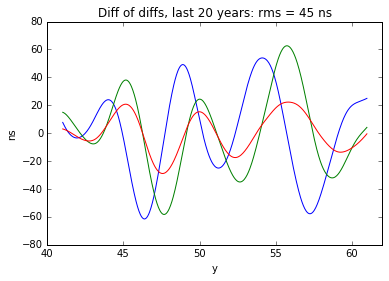

In [63]:
plotdiff(bsp, 'de421.bsp', csol, csol4, 'DE436 - DE421 Sun (solid = eph., dashed = int.)', degree=1, plotdiff=True)

Need both Neptune and Uranus

In [64]:
masses421b = masses436.copy()

masses421b[7] = masses421[7]
masses421b[8] = masses421[8]

csol4 = cintegrate(gety0('de421.bsp'), masses421b)

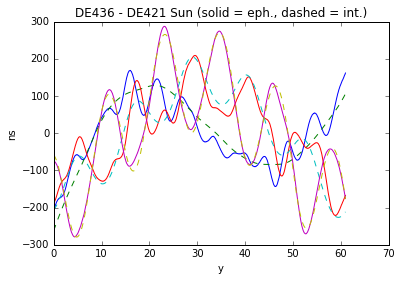

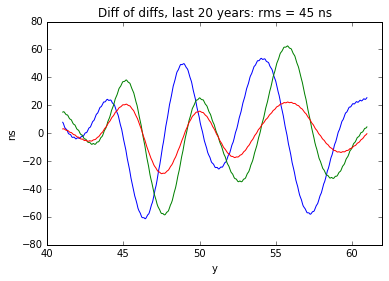

In [65]:
plotdiff(bsp, 'de421.bsp', csol, csol4, 'DE436 - DE421 Sun (solid = eph., dashed = int.)', degree=1, plotdiff=True)

Need to move Sun and Jupiter for best fit. There's still what looks like a Jupiter signature. Sun only gives 130 ns rms (last 20 years); Jupiter only gives 100 ns rms. 

In [66]:
masses421b = masses436.copy()

masses421b[7] = masses421[7]
masses421b[8] = masses421[8]

y0mod = gety0(bsp)

for p in [0,5]:
    y0mod[6*p:6*p+6] = sel(gety0('de421.bsp'),p)

csol4 = cintegrate(y0mod, masses421b)

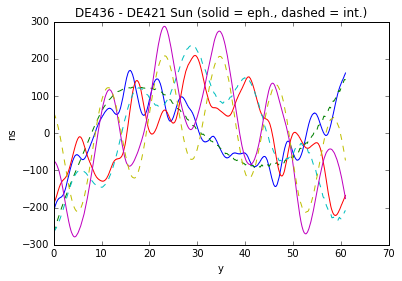

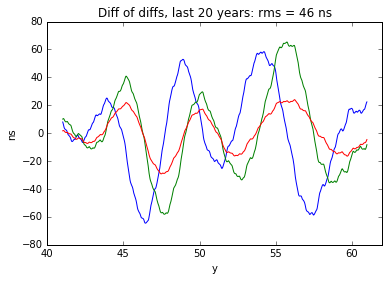

In [67]:
plotdiff(bsp, 'de421.bsp', csol, csol4, 'DE436 - DE421 Sun (solid = eph., dashed = int.)', degree=1, plotdiff=True)

Make a function that we can use to minimize.

In [68]:
def residual(bsp,bsp2,csol,degree=0):
    p = 0 # look at Sun

    ts = jdates - jdates[0]
    ind = np.where(ts > ts[-1] - 20 * 365.25)[0][0] # fit only the last 20 years

    pos, vel = getplanet(0,jdates[ind:],bsp=bsp)
    pos2, vel2 = getplanet(0,jdates[ind:],bsp=bsp2)

    x = ts[ind:] * 86400
    ypart = [(pos[:,i] - pos2[:,i]) - sin.interp1d(t(csol),sel(csol,p)[:,i],kind='cubic')(x) for i in range(3)]
    
    def resfunc(csol2):
        rms = 0
        for i in range(3):
            x = ts[ind:] * 86400
            y = 1e9*(ypart[i] + sin.interp1d(t(csol2),sel(csol2,p)[:,i],kind='cubic')(x))

            x, ym, dy = project(ts[ind:]/365.25,y,degree=degree)

            rms += np.var(dy)

        return math.sqrt(rms)
    
    return resfunc

In [69]:
dx = (y0 - y0mod)[6*5:6*5+6]

def f(x):
    y0modj = y0mod.copy()
    y0modj[6*5:6*5+6] += np.array(x) * dx

    csolf = cintegrate(y0modj, masses421b)
    res = residual(bsp, 'de421.bsp', csol, degree=1)(csolf)
    
    print(x,res)
    return res

Hmm, the attempt to optimize over the initial Jupiter pos/vel seems doomed here.

In [70]:
# so.minimize(f,np.array([0,0,0,0,0,0]))

[ 0.  0.  0.  0.  0.  0.] 46.10381105481965
[  1.49011612e-08   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00] 46.10283839588444
[  0.00000000e+00   1.49011612e-08   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00] 46.10242750728882
[  0.00000000e+00   0.00000000e+00   1.49011612e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00] 46.10287698149253
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.49011612e-08
   0.00000000e+00   0.00000000e+00] 46.10381105481965
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.49011612e-08   0.00000000e+00] 46.10238667951207
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.49011612e-08] 46.10281302088554
[ 0.  0.  0.  0.  0.  0.] 46.10381105481965
[ 0.37790547  0.5375473   0.36291387  0.          0.55341004  0.38776437] 681.6086360037654
[ 0.37790547  0.5375473   0.36291387  0.          0.55341004  0.38776437] 681.6086

KeyboardInterrupt: 

## Make BayesEphem bases

### Try a rate in the mass of the Sun

In [81]:
massesvar = np.concatenate((masses436,[-1.0e-13/(3600 * 24 * 365.25)]))

In [82]:
cref = cintegrate(gety0(),masses436)
y0ref = cref[0,1:]

cvar = cintegrate(y0ref,massesvar)

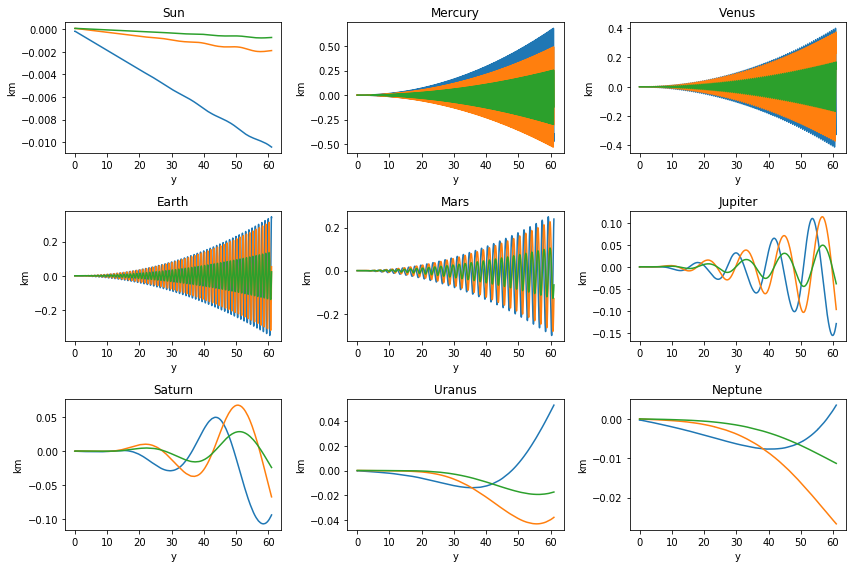

In [91]:
pp.figure(figsize=(12,8))

for p in range(9):
    pp.subplot(3,3,p+1)

    tref, pref = t(cref), sel(cref,p)
    tvar, pvar = t(cvar), sel(cvar,p)

    for i in range(3):
        pp.plot(tref/86400/365.25,
                csec * (sin.interp1d(tvar,pvar[:,i],kind='cubic')(tref) - pref[:,i]))
    
    pp.xlabel('y'); pp.ylabel('km')
    pp.title(planets[p])
    
pp.tight_layout()

### Partials

In [ ]:
# pos/vel perturbation, with vel scaling

def dp(i,j,d):
    """Perturb planet i, component j, by d (scaled by 1e-8 for velocities.)"""
    ret = np.zeros(6*9,'d')
    ret[i*6+j] = d if j < 3 else d * 1e-8
    return ret

Work with DE436 masses and initial conditions. Perturb Jupiter.

In [ ]:
massesref = masses436.copy()

cref = cintegrate(gety0(),massesref)
y0ref = cref[0,1:]

jfinite = [integrate(y0ref + dp(5,i,1e-4), massesref)
           for i in range(6)]

Make partials, possibly restricting to last twenty years, and possibly projecting out polynomial.

In [ ]:
def getpartials(cref,jfinite,dx,p=0,plot=False,end=False,degree=None,tp=None):
    if plot: pp.figure(figsize=(9,5))

    if tp is None:
        tp = t(jfinite[0])

        if end:
            indmin = np.where(tp > tp[-1] - 20 * 365.25 * 86400)[0][0]
            indmax = -1
        else:
            indmin = 0
            indmax = np.where(tp > 20 * 365.25 * 86400)[0][0]
    else:
        indmin, indmax = 0, None
            
    jpart = np.zeros((6,len(tp[indmin:indmax]),3),'d')

    for i in range(6):
        if plot: pp.subplot(3,3,i+1)
        
        for j in range(3):
            x, ym, dm = project(tp[indmin:indmax] / 86400 / 365.25,
                                (sin.interp1d(t(jfinite[i]),sel(jfinite[i],p)[:,j],kind='cubic')(tp[indmin:indmax]) - 
                                 sin.interp1d(t(cref),sel(cref,p)[:,j],kind='cubic')(tp[indmin:indmax])) / dx[i],
                                degree=degree)    
            jpart[i,:,j] = dm

            if plot: pp.plot(x,dm)

    if plot: pp.tight_layout()
        
    return tp[indmin:indmax], jpart

Sun partials w.r.t. changing Jupiter initial conditions. Units of s/s (top row) and s/(s/s) = s (bottom row).

In [ ]:
dx = [1e-4,1e-4,1e-4,1e-12,1e-12,1e-12]
tp, jpart = getpartials(cref,jfinite,dx,p=0,plot=True,end=True,degree=1)

Function to clean up higher frequencies if needed.

In [ ]:
def downfilter(array, fcut=10, plot=False):
    fft = np.fft.fft(array)
    fft[fcut:-fcut] = 0.0
    ifft = np.fft.ifft(fft).real
    
    if plot:
        pp.plot(array)
        pp.plot(ifft)
        
    return ifft

Interpolate orbits to a uniform grid between integration limits, and return with JD. Apply rolling mean or FFT smoothing if requested.

In [ ]:
def resample(tp,jpart,window=None,fft=None):
    jdates_integ = jdates[0] + tp/86400       # JD

    # jdates_export = np.linspace(ephem.julian_date('2000/1/1'),ephem.julian_date('2020/12/31'),2000)
    jdates_export = np.linspace(jdates_integ[0],jdates_integ[-1],2000)

    dates_export = jdates_export - 2400000.5  # MJD
    
    jpart_export = np.zeros((6,2000,3),'d')

    for i in range(6):
        for k in range(3):
            jpart_export[i,:,k] = sin.interp1d(jdates_integ,jpart[i,:,k],
                                               kind='cubic')(jdates_export)

            _, _, jpart_export[i,:,k] = project(jdates_export, jpart_export[i,:,k], degree=1)

            if window:
                jpart_export[i,:,k] = pd.rolling_mean(jpart_export[i,:,k],window,center=True)
                _, _, jpart_export[i,window:-window,k] = project(jdates_export[window:-window],
                                                                 jpart_export[i,window:-window,k], degree=1)
                
            if fft:
                jpart_export[i,:,k] = downfilter(jpart_export[i,:,k], fft)
                _, _, jpart_export[i,:,k] = project(jdates_export[:],
                                                    jpart_export[i,:,k], degree=1)

    if window:
        dates_export = dates_export[window:-window]
        jpart_export = jpart_export[:,window:-window,:].copy()    
        
    return dates_export, jpart_export

Make SVD basis, return basis and transformation matrix, or basis and SVD matrices.

In [ ]:
def makesvd(rtp, rjpart, window=None, full_matrices=False):
    U, S, Vh = sla.svd(rjpart.reshape((rjpart.shape[0],rjpart.shape[1]*3)).copy(),full_matrices=False)
    jsvd = Vh.reshape((rjpart.shape[0],rjpart.shape[1],3)).copy()

    print(S)
    
    mult = rjpart.shape[0]/6
    
    pp.figure(figsize=(9,mult*5))

    for j in range(rjpart.shape[0]):
        pp.subplot(mult * 3,3,j+1)

        for i in range(3):
            if window:
                jsvd[j,:,i] = pd.rolling_mean(jsvd[j,:,i],window,center=True)
            
            pp.plot(rtp / 365.25 / 86400,
                    jsvd[j,:,i])

        # pp.axis(ymin=-0.03,ymax=0.03)

    pp.tight_layout()
    
    if full_matrices:
        return jsvd, S, U
    else:
        return jsvd, (np.diag(1/S) @ np.linalg.inv(U)).T

Make SVD basis.

In [ ]:
rtp, rjpart = resample(tp,jpart)
jsvd, S, U = makesvd(rtp, rjpart, full_matrices=True)

Check. Remember $A = U S V^T$.

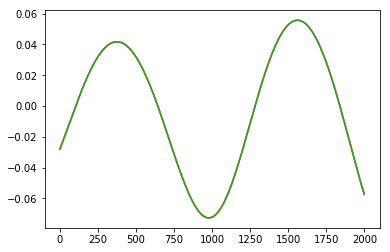

In [73]:
pp.plot(rjpart[1,:,1])

pp.plot(np.einsum('j,j,jk->k',U[1,:],S[:],jsvd[:,:,1]))
pp.plot(U[1,:] @ np.diag(S[:]) @ jsvd[:,:,1])

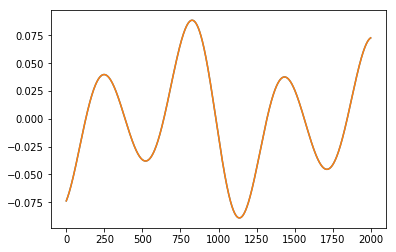

In [74]:
d = np.random.randn(6)
pp.plot(d @ jsvd[:,:,0])

c = d @ np.diag(1/S) @ np.linalg.inv(U)
c = np.einsum('i,i,ij->j',d,1/S,np.linalg.inv(U))
cmat = (np.diag(1/S) @ np.linalg.inv(U)).T

pp.plot(cmat @ d @ rjpart[:,:,0])

Thus the conversion matrix to go back to dx and dv is $(S^{-1} U^{-1})^T$.

Export for Steve.

In [ ]:
jsvd, cmat = makesvd(rtp, rjpart, full_matrices=False)

In [61]:
os.mkdir('partials-export-20180320')

In [460]:
np.save('partials-export-20180320/jupiter-dynamic-mjd.npy',rtp)
np.save('partials-export-20180320/jupiter-dynamic-xyz.npy',jsvd)
np.save('partials-export-20180320/jupiter-dynamic-cmat.npy',cmat)

In [469]:
!tar zcvf partials-export-20180320/jupiter-dynamic.tar.gz partials-export-20180320/jupiter-dynamic-*.npy

a jupiter-dynamic-cmat.npy
a jupiter-dynamic-mjd.npy
a jupiter-dynamic-xyz.npy


### See effect of Jupiter parameter posteriors from Stephen's runs

Load parameter posteriors from Steve's run for DE436, Jupiter posteriors only

In [76]:
jdpost = np.load('mcmc-posteriors-20180406/jup_dynamic_de436.npz')['arr_0']

In [77]:
jdpost.shape

(97300, 6)

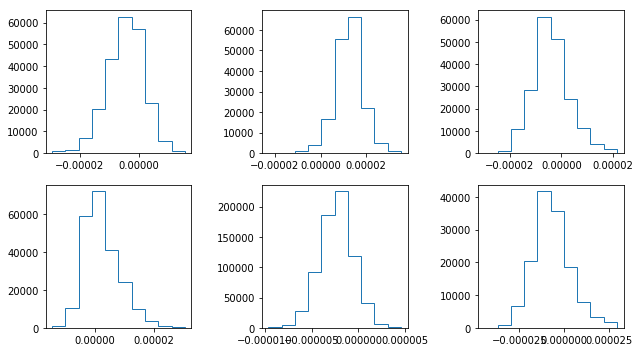

In [81]:
pp.figure(figsize=(9,5))

for i in range(6):
    pp.subplot(2,3,i+1)
    pp.hist(jdpost[:,i],histtype='step',density=True)
    pp.tight_layout()
    
pp.tight_layout()

Convert to physical posteriors by multiplying with conversion matrix. These are natively s and s/s.

In [82]:
jdpostphys = np.einsum('ij,kj->ki',cmat,jdpost)

In [83]:
jdpostphys.shape

(97300, 6)

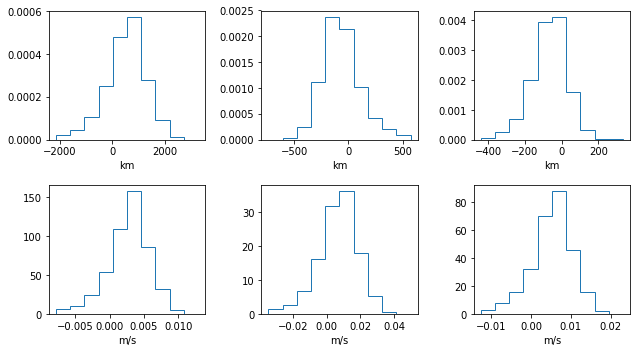

In [87]:
fig = pp.figure(figsize=(9,5))

for i in range(6):
    pp.subplot(2,3,i+1)
    norm = csec if i < 3 else csec * 1e3
    pp.hist(norm * jdpostphys[:,i],histtype='step',density=True)
    pp.tight_layout()
    pp.xlabel('km' if i < 3 else 'm/s')
    
pp.tight_layout()

Get the **Jupiter** partials to reconstruct Jupiter orbital corrections.

In [ ]:
dx = [1e-4,1e-4,1e-4,1e-12,1e-12,1e-12]
jtp, jjpart = getpartials(cref,jfinite,dx,p=5,plot=True,end=True,degree=1)

Multiply partials by physical parameters, using a subset of the chain.

In [89]:
jdpostorbs = csec * np.einsum('li,ijk->ljk',jdpostphys[::500,:],jjpart) # km

In [90]:
jdpostorbs.shape

(195, 12986, 3)

Plot against MJD. Here units are km

In [ ]:
mjd = jdates[0] + tp/86400 - 2400000.5

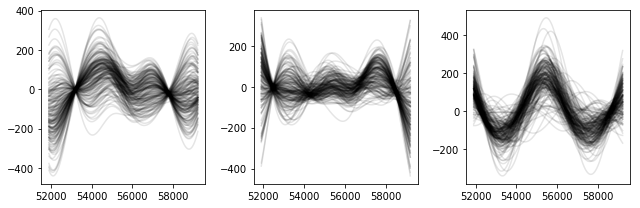

In [92]:
pp.figure(figsize=(9,3))

for obs in range(3):
    pp.subplot(1,3,obs+1)

    for i in range(jdpostorbs.shape[0]):
        pp.plot(mjd, jdpostorbs[i,:,obs], 'k', alpha=0.1)
        
pp.tight_layout()

Plot Sun orbit correction posteriors against MJD.

In [93]:
sjdpostorbs = csec * np.einsum('li,ijk->ljk',jdpostphys[::500,:],jpart)

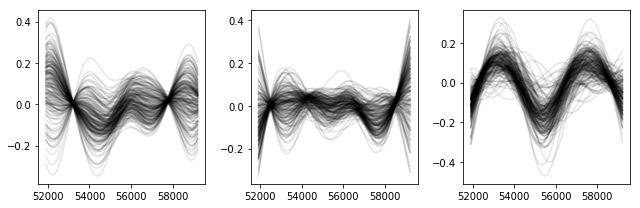

In [94]:
pp.figure(figsize=(9,3))

for obs in range(3):
    pp.subplot(1,3,obs+1)

    for i in range(sjdpostorbs.shape[0]):
        pp.plot(mjd, sjdpostorbs[i,:,obs], 'k', alpha=0.1)
        
pp.tight_layout()

### Compare with JPL's Jupiter priors

**TLDR**: see plot at the end of this section

Jupiter Set-III elements covariance matrix from Bill.

In [201]:
APCSCALE = 6
APCNAME = ['DMW5','DP5','DQ5','EDW5','DA5','DE5']

APCOV1 = np.zeros((6,6),'d')

APCOV1[0,0:1] = [ 1.527621387618E-15]
APCOV1[1,0:2] = [ 1.058311905401E-16,  9.908144821626E-16]
APCOV1[2,0:3] = [ 1.325206907371E-16,  7.800126497261E-16,  1.484869687029E-15]
APCOV1[3,0:4] = [-5.554347232525E-17, -1.805266759308E-18, -3.219245713312E-18,  3.943475941450E-18]
APCOV1[4,0:5] = [ 5.829025102220E-17,  2.411095852154E-18,  3.120922611115E-18, -1.149409771728E-18,  2.730094171917E-18]
APCOV1[5,0:6] = [-1.517335230324E-16, -1.514060345995E-17, -1.982573561138E-17,  7.340771399985E-18, -4.843232999649E-18,  1.686941960642E-17]

for i in range(6):
    for j in range(i+1,6):
        APCOV1[i,j] = APCOV1[j,i]

In [202]:
%load_ext fortranmagic

/Users/vallis/anaconda3/lib/python3.6/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


Code from Bill to compute partials.

In [203]:
%%fortran
      SUBROUTINE VCROSS(a, b, cross)
      REAL(8), DIMENSION(3), INTENT(IN) :: a, b
      REAL(8), DIMENSION(3), INTENT(OUT) :: cross

      cross(1) = a(2) * b(3) - a(3) * b(2)
      cross(2) = a(3) * b(1) - a(1) * b(3)
      cross(3) = a(1) * b(2) - a(2) * b(1)
      END SUBROUTINE VCROSS

      SUBROUTINE EMSMAG(R,SR)
      REAL(8), DIMENSION(3), INTENT(IN) :: R
      REAL(8), INTENT(OUT) :: SR
    
      SR = SQRT(R(1)*R(1) + R(2)*R(2) + R(3)*R(3))
      END SUBROUTINE EMSMAG
    
      SUBROUTINE EMSDOT(a, b, dot)
      REAL(8), DIMENSION(3), INTENT(IN) :: a, b
      REAL(8), INTENT(OUT) :: dot
            
      dot = a(1)*b(1) + a(2)*b(2) + a(3)*b(3)
      END SUBROUTINE EMSDOT
    
      SUBROUTINE VNORM(v, norm)
      REAL(8), DIMENSION(3), INTENT(INOUT) :: v
      REAL(8), INTENT(OUT) :: norm
            
      CALL EMSMAG(v, norm)
    
      DO 1 I=1,3
   1  v(I) = v(I) / norm
      END SUBROUTINE VNORM
    
      SUBROUTINE S3PAR6(RMU,R,PX)   

c SET III Formulation of Brouwer & Clemence (pg.241)
c
c     S3PAR6(RMU,R,PX)
c
c                   d(x,y,z,x-dot,y-dot,z-dot)
c     computes PX = --------------------------
c                         d(set III)
c
c
c     where   setIII = DMWi, DPi, DQi, EDWi, DAi, DEi
c
c             RMU = GMsun + GMi
c
c             R = x, y, z, x-dot, y-dot, z-dot, t-t0
c
c     Note : t-t0 is time since epoch of partials
c
c     in  [ (au) and (au/day) / (radians) ]
c
c The formulation follows (Standish JPL IOM 314.6-629, 1985)

      IMPLICIT DOUBLE PRECISION (A-H,O-Z)
      REAL(8), INTENT(IN) :: RMU
      REAL(8), DIMENSION(7), INTENT(IN) :: R
      REAL(8), DIMENSION(6,6), INTENT(OUT) :: PX
            
      REAL(8), DIMENSION(3,3) :: PQR
      REAL(8), DIMENSION(8) :: W

      save

c     R = r X r-dot 

      CALL VCROSS(R,R(4),PQR(1,3))   


c     P = r-dot X h  -  mu * r-cap   (Danby, pg 122)

      CALL VCROSS(R(4),PQR(1,3),PQR(1,1))  

      CALL EMSMAG(R,SR)   
      DO 1 I=1,3  
   1  PQR(I,1)=PQR(I,1)-RMU*R(I)/SR 


c     Q = R X P

      CALL VCROSS(PQR(1,3),PQR(1,1),PQR(1,2))    


c Normalize P, Q, R

      DO 2 I=1,3  
   2  CALL VNORM(PQR(1,I),SH) 


c  Compute v**2, r r-dot, a, n, (1-ee), ee, e, ae(1-ee)

      CALL EMSDOT(R(4),R(4),VV) 
      CALL EMSDOT(R,R(4),RRD)   

      A=SR*RMU/(2.D0*RMU-SR*VV)     
      EN=DSQRT(RMU/A**3)
      PAR=SH*SH/(RMU*A) 
      EE=1.D0-PAR 
      E=DSQRT(EE) 
      AEPAR=A*E*PAR     

C  H adn K  (Brouwer & Clemence, pg. 237)

      CH=(SR-A*(1.D0+EE))/AEPAR     
      CK=(RRD/((A*EN)**2*E))*(1.D0+SR/(A*PAR))  

c  H-dot and K-dot

      CHD=RRD/(SR*AEPAR)
      CKD=(2.D0*(A-SR)+A*EE)/AEPAR  
C     
      FAC=-RMU/SR**3    

c  Load r, r-dot and r-dot-dot into W

      DO 3 I=1,3  
      W(I)=R(I)   
      W(I+3)=R(I+3)     
   3  W(I+6)=FAC*W(I)   

c  DP = P X r; DQ = Q X r; EDW = (- r-dot/n + R X r)/e

c  P X r, P X r-dot, Q X r, Q X r-dot, R X r and R X r-dot into PX

      DO 4 I=1,4,3
      DO 4 J=1,3  
   4  CALL VCROSS(PQR(1,J),R(I),PX(I,J+1)) 
   

      DO 5 I=1,6  

c  DMW = r-dot / n

      PX(I,1)=W(I+3)/EN 

c  DA = r - 3/2 t r-dot; r-dot - 3/2 t r-dot-dot - 3/2 r-dot

      PX(I,5)=W(I)-1.5D0*R(7)*W(I+3)

c  DE = H r + K r-dot, 
c          H r-dot + K r-dot-dot  +  h-dot r + K-dot r-dot

      PX(I,6)=CH*W(I)+CK*W(I+3)     

c  (finish the rest of EDW)

   5  PX(I,4)=(PX(I,4)-W(I+3)/EN)/E 


      DO 6 I=1,3  

c  (finish the last term of DA)

      PX(I+3,5)=PX(I+3,5)-1.5D0*W(I+3)    

c  (finish the last terms of DE)

   6  PX(I+3,6)=PX(I+3,6)+CHD*W(I)+CKD*W(I+3)   
              
      RETURN
      END

In [204]:
AU = 149597870.700 # km

def xxdot(dates,tref=2440400.5):
    x, xdot = getplanet(5,dates) # s, s/s
    
    x *= (csec / AU)            # AU
    xdot *= (csec / AU * 86400) # AU/d
        
    t = np.array(dates) - tref
    
    res = np.hstack((x, xdot, t))

    if res.shape[0] == 1:
        return res[0,:]
    else:
        return res

In [205]:
xxdot(2451544.5,tref=2451544.0)

array([ 3.99632096e+00,  2.73099357e+00,  1.07327427e+00, -4.55809905e-03,
        5.87800793e-03,  2.63056855e-03,  5.00000000e-01])

In [206]:
GMS_AU3d2 = GMS / ((AU * 1e3)**3 / 86400**2) # m3s−2 -> AU3d-2

In [207]:
GMJ_AU3d2 = masses436[5] * GMS_AU3d2

From Bill Folkner:

    Partials at time no.   1  01-JAN-2000 00:00:00.0000
               Julian date    0.2451544500000000D+07
               Seconds past reference   -0.4320000000000000D+05

In [208]:
pfolk = np.array([[ 1.20262807773396e10,  -9.11401212616218e08,   6.40787059136829e06,  -1.52733213343214e07,   -4.73450349092525e08,   6.06449895432699e08],
                  [-1.43268663380316e10,   1.03431995771853e07,  -1.10614953336483e08,   2.70497680446158e08,    6.09298914468547e08,  -1.21734424415590e09],
                  [-6.43391905757151e09,   2.66046657997218e07,   2.57569281635618e08,  -6.31741799726461e08,    2.72692531635397e08,  -5.36536559398573e08]]).T

In [105]:
pfolk

array([[ 1.20262808e+10, -1.43268663e+10, -6.43391906e+09],
       [-9.11401213e+08,  1.03431996e+07,  2.66046658e+07],
       [ 6.40787059e+06, -1.10614953e+08,  2.57569282e+08],
       [-1.52733213e+07,  2.70497680e+08, -6.31741800e+08],
       [-4.73450349e+08,  6.09298914e+08,  2.72692532e+08],
       [ 6.06449895e+08, -1.21734424e+09, -5.36536559e+08]])

Not too bad, except for eccentricity.

In [106]:
for par, ind in [('DA',4),('DE',5),('DP',1),('DQ',2),('DMW',0),('EDW',3)]:
    print(par, AU * s3par6(GMS_AU3d2 + GMJ_AU3d2, xxdot(0.24515445e7))[:3,ind])

DA [ 1.19961792e+10 -1.42904543e+10 -6.41764538e+09]
DE [-9.24063688e+08  4.17108598e+07  4.03862445e+07]
DP [ 6.46037684e+06 -1.13691617e+08  2.65238198e+08]
DQ [-1.52913657e+07  2.69101964e+08 -6.27804600e+08]
DMW [-4.66417397e+08  6.01479942e+08  2.69178647e+08]
EDW [ 6.14221613e+08 -1.23277496e+09 -5.43376795e+08]


These are in `AU/[set III unit]`.

In [ ]:
jd = mjd + 2400000.5

In [209]:
partial = np.zeros((6,len(jd),3),'d')

for i in range(len(jd)):
    partial[:,i,:] = s3par6(GMS_AU3d2 + GMJ_AU3d2, xxdot(jd[i]))[:3,:].T

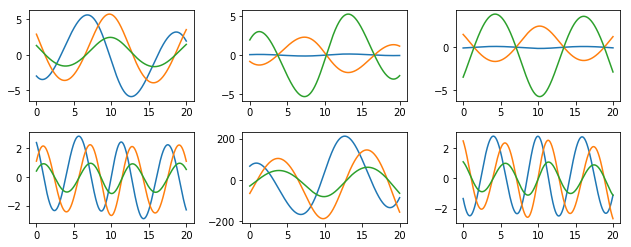

In [210]:
ppartial = np.zeros_like(partial)

pp.figure(figsize=(9,5))

for i in range(6):
    pp.subplot(3,3,i+1)
        
    for j in range(3):
        x, ym, dm = project((jd - jd[0])/365.25,partial[i,:,j],degree=1)    
        ppartial[i,:,j] = dm
        pp.plot(x,dm)
        
pp.tight_layout()

See a distribution of orbit corrections according to covariance matrix.

In [211]:
l = np.linalg.cholesky(APCOV1)

def randx():
    de = np.dot(l, np.random.randn(6)) # I've checked this is the correct usage to get vectors with covariance APCOV1
    
    return  AU * np.einsum('ijk,i->jk',ppartial,de) # km

In [212]:
randx().shape

(12986, 3)

In [213]:
arandx = np.zeros((200,12986, 3))
for i in range(200):
    arandx[i,:,:] = randx()

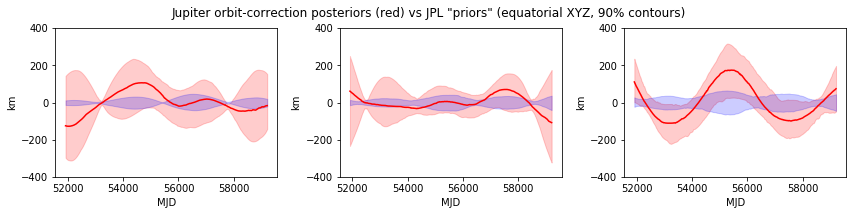

In [114]:
fudge = 1

fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3)

for obs in range(3):
    axes[obs].fill_between(mjd,np.percentile(jdpostorbs,5,axis=0)[:,obs],
                               np.percentile(jdpostorbs,95,axis=0)[:,obs],color='r',alpha=0.2)
    axes[obs].plot(mjd,np.median(jdpostorbs,axis=0)[:,obs],'r')

for obs in range(3):
    axes[obs].fill_between(mjd,np.percentile(fudge*arandx,5,axis=0)[:,obs],
                               np.percentile(fudge*arandx,95,axis=0)[:,obs],color='b',alpha=0.2)
    # axes[obs].plot(mjd,np.median(arandx,axis=0)[:,obs],'b')
    
for ax in axes:
    ax.set_xlabel('MJD')
    ax.set_ylabel('km')
    
    ax.set_ylim([-400,400])
    
pp.suptitle('Jupiter orbit-correction posteriors (red) vs JPL "priors" (equatorial XYZ, 90% contours)');

pp.tight_layout(rect=[0,0,1,0.95])

# pp.savefig('mcmc-posteriors-20180406/posterior-vs-prior.png')

### Partials w.r.t. Sun's and Jupiter's initial parameters

Perturb Sun

In [ ]:
sfinite = [integrate(y0ref + dp(0,i,1e-4), massesref) for i in range(6)]

In [ ]:
dx = np.array([1e-4,1e-4,1e-4,1e-12,1e-12,1e-12])

In [ ]:
sp, spart = getpartials(cref,sfinite,dx,p=0,plot=True,end=True,degree=1,tp=tp)

[  1.80673702e+08   1.13018204e+07   1.64633802e+06   1.82557623e-01
   1.40033281e-01   2.69561817e-02]


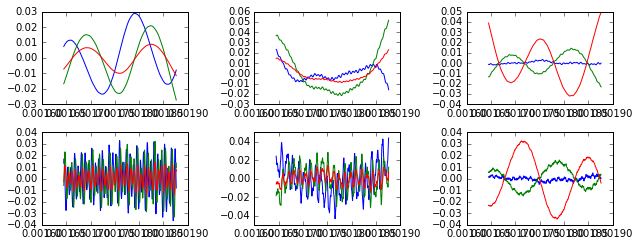

In [461]:
stp, rspart = resample(sp, spart, window=None)
ssvd, scmat = makesvd(stp, rspart, window=None)

[  1.80131583e+08   1.11504003e+07   1.64231770e+06   7.99193572e-02
   2.67733133e-02   1.64005117e-02]


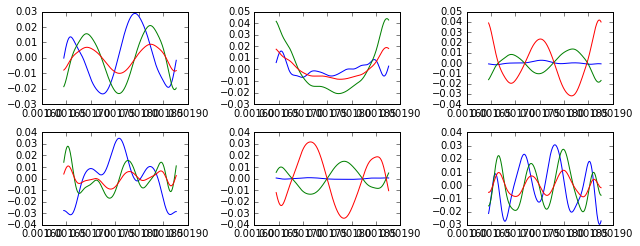

In [462]:
stp, rspart = resample(sp, spart, window=None, fft=8)
ssvd, scmat = makesvd(stp, rspart, window=None)

Put them together

[2.64199540e+08 2.24420204e+07 2.53249286e+06 2.27634417e+06
 8.31516843e+05 6.81609904e+05 1.72818244e-01 1.22889463e-01
 3.89431371e-02 1.99719287e-02 2.35881772e-03 1.26540007e-03]


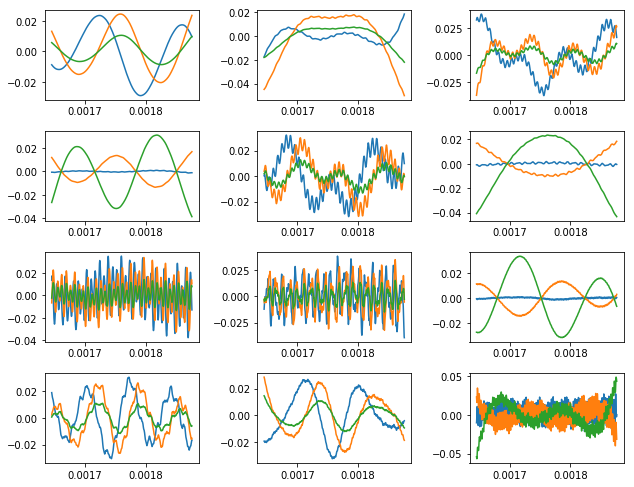

In [121]:
rtp2, rjpart2 = resample(tp,jpart)
rsp2, rspart2 = resample(sp,spart)

rjspart = np.vstack((rjpart2,rspart2))
jsvd, jscmat = makesvd(rtp2, rjspart)

In [ ]:
rtp2, rjpart2 = resample(tp,jpart,fft=8)
rsp2, rspart2 = resample(sp,spart,fft=8)

rjspart = np.vstack((rjpart2,rspart2))
jssvd, jscmat = makesvd(rtp2, rjspart)

In [465]:
np.save('partials-export-20180320/jupitersun-dynamic-mjd.npy',rtp2)
np.save('partials-export-20180320/jupitersun-dynamic-xyz.npy',jssvd)
np.save('partials-export-20180320/jupitersun-dynamic-cmat.npy',jscmat)

In [468]:
!tar zcvf partials-export-20180320/jupitersun-dynamic.tar.gz partials-export-20180320/jupitersun-dynamic-*.npy

a jupitersun-dynamic-cmat.npy
a jupitersun-dynamic-mjd.npy
a jupitersun-dynamic-xyz.npy


### See effect of Jupiter/Sun parameter posteriors from Stephen's runs

In [123]:
jsdpost = np.load('mcmc-posteriors-20180406/jupsun_dynamic_de436.npz')['arr_0']

In [125]:
jsdpost.shape

(95100, 12)

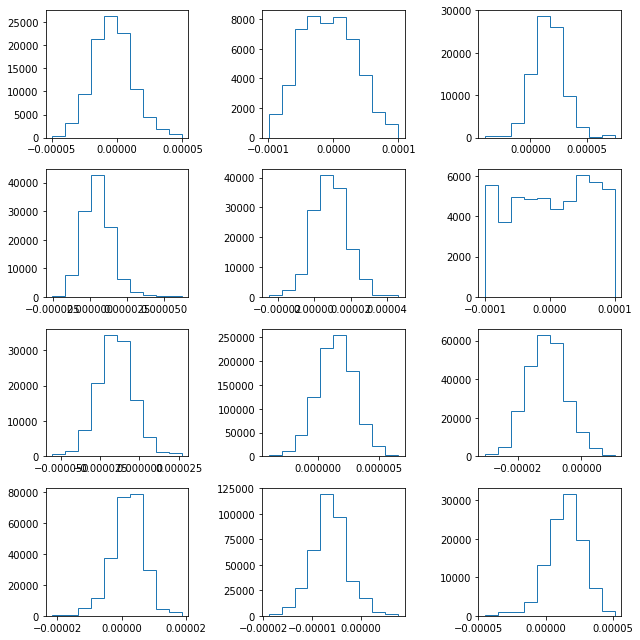

In [129]:
pp.figure(figsize=(9,9))

for i in range(12):
    pp.subplot(4,3,i+1)
    pp.hist(jsdpost[:,i],histtype='step',density=True)
    pp.tight_layout()
    
pp.tight_layout()

In [130]:
jsdpostphys = np.einsum('ij,kj->ki',jscmat,jsdpost)

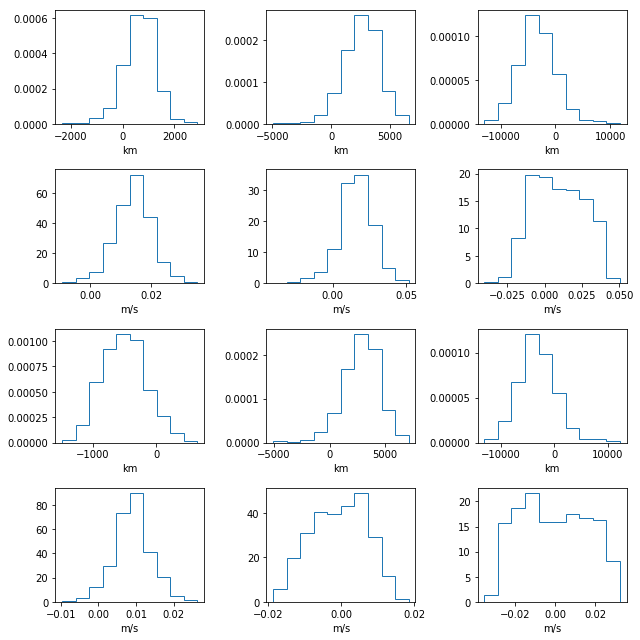

In [132]:
fig = pp.figure(figsize=(9,9))

for i in range(12):
    pp.subplot(4,3,i+1)
    norm = csec if i in [0,1,2,6,7,8] else csec * 1e3
    pp.hist(norm * jsdpostphys[:,i],histtype='step',density=True)
    pp.tight_layout()
    pp.xlabel('km' if i in [0,1,2,6,7,8] else 'm/s')
    
pp.tight_layout()

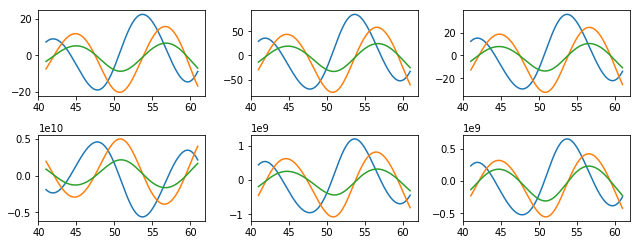

In [167]:
dx = [1e-4,1e-4,1e-4,1e-12,1e-12,1e-12]
jstp, jspart = getpartials(cref,sfinite,dx,p=5,plot=True,end=True,degree=1)

In [142]:
np.vstack((jjpart,jspart)).shape

(12, 12986, 3)

In [141]:
jsdpostorbs = csec * np.einsum('li,ijk->ljk',jsdpostphys[::500,:],np.vstack((jjpart,jspart))) # km

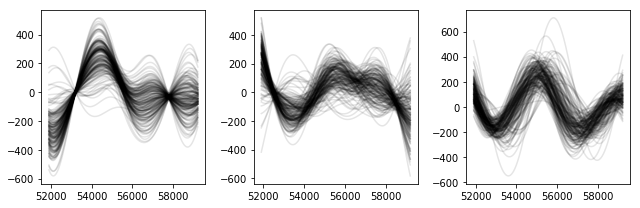

In [144]:
pp.figure(figsize=(9,3))

for obs in range(3):
    pp.subplot(1,3,obs+1)

    for i in range(jsdpostorbs.shape[0]):
        pp.plot(mjd, jsdpostorbs[i,:,obs], 'k', alpha=0.1)
        
pp.tight_layout()

In [ ]:
def plbsp(jd,bsp,axes,color,planet=5,bspref='de436t.bsp',equatorial=True):
    p, v = getplanet(5, jd, bsp=bsp)
    pref, vref = getplanet(5, jd, bsp=bspref)
    
    if not equatorial:
        p = eq2ecl_vec(p)
        pref = eq2ecl_vec(pref)
    
    for obs in range(3):
        _, _, dp = project(jd, p[:,obs] - pref[:,obs], degree=1)
        axes[obs].plot(jd - 2400000.5, csec * dp, color + '--')
    
    return p

In [ ]:
def eq2ecl_tens(array):
    ret = np.zeros_like(array)
    for i in range(array.shape[0]):
        ret[i,:,:] = eq2ecl_vec(array[i,:,:])
    return ret

def plorb(array,axes,color,median=True,equatorial=True):
    if not equatorial: array = eq2ecl_tens(array)
    
    for obs in range(3):
        axes[obs].fill_between(mjd,np.percentile(array,5,axis=0)[:,obs],
                                   np.percentile(array,95,axis=0)[:,obs],color=color,alpha=0.2)
        axes[obs].plot(mjd,np.median(array,axis=0)[:,obs],color)

def pltitle(axes):
    for i,ax in enumerate(axes):
        ax.set_xlabel('MJD')
        ax.set_ylabel('xyz'[i] + ' [km]')

        ax.set_ylim([-400,400])    

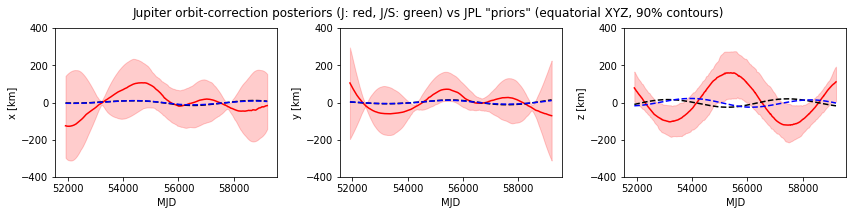

In [197]:
fudge = 1

fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3)

plorb(jdpostorbs,axes,'r',equatorial=False)
plbsp(jd,'de435t.bsp',axes,'k',equatorial=False)
plbsp(jd,'de430t.bsp',axes,'b',equatorial=False)
# plorb(jsdpostorbs,axes,'g')
# plorb(fudge*arandx,axes,'b',False)
    
pltitle(axes)
    
pp.suptitle('Jupiter orbit-correction posteriors (J: red, J/S: green) vs JPL "priors" (equatorial XYZ, 90% contours)');
pp.tight_layout(rect=[0,0,1,0.95])

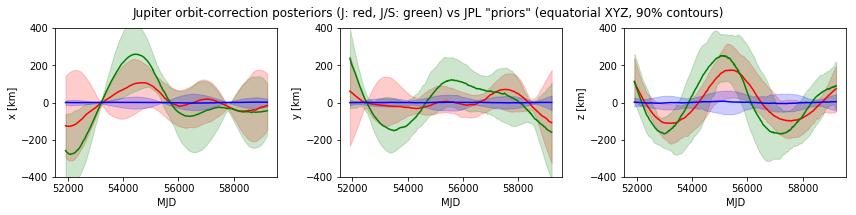

In [161]:
fudge = 1

fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3)

def plorb(array,color,median=True):
    for obs in range(3):
        axes[obs].fill_between(mjd,np.percentile(array,5,axis=0)[:,obs],
                                   np.percentile(array,95,axis=0)[:,obs],color=color,alpha=0.2)
        axes[obs].plot(mjd,np.median(array,axis=0)[:,obs],color)

plorb(jdpostorbs,'r')
plorb(jsdpostorbs,'g')
plorb(fudge*arandx,'b',False)
    
for i,ax in enumerate(axes):
    ax.set_xlabel('MJD')
    ax.set_ylabel('xyz'[i] + ' [km]')
    
    ax.set_ylim([-400,400])
    
pp.suptitle('Jupiter orbit-correction posteriors (J: red, J/S: green) vs JPL "priors" (equatorial XYZ, 90% contours)');

pp.tight_layout(rect=[0,0,1,0.95])

pp.savefig('mcmc-posteriors-20180406/posterior-vs-prior.png')

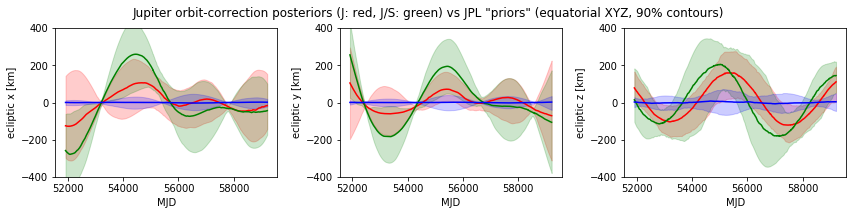

In [164]:
fudge = 1

fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3)

def plorb(array,color,median=True):
    for obs in range(3):
        axes[obs].fill_between(mjd,np.percentile(array,5,axis=0)[:,obs],
                                   np.percentile(array,95,axis=0)[:,obs],color=color,alpha=0.2)
        axes[obs].plot(mjd,np.median(array,axis=0)[:,obs],color)

plorb(eq2ecl_tens(jdpostorbs),'r')
plorb(eq2ecl_tens(jsdpostorbs),'g')
plorb(eq2ecl_tens(fudge*arandx),'b',False)
    
for i,ax in enumerate(axes):
    ax.set_xlabel('MJD')
    ax.set_ylabel('ecliptic ' + 'xyz'[i] + ' [km]')
    
    ax.set_ylim([-400,400])
    
pp.suptitle('Jupiter orbit-correction posteriors (J: red, J/S: green) vs JPL "priors" (ecliptic XYZ, 90% contours)');

pp.tight_layout(rect=[0,0,1,0.95])

pp.savefig('mcmc-posteriors-20180406/posterior-vs-prior-ecl.png')

### More re posteriors

    gsiscp -C pcdev1.ligo.uwm.edu:/home/stephen.taylor/NANOGrav/nano11yr_scripts/chains_nano11_tests/dynamic_bayesephem/DE421/bayesephem_True/jup/limit_False/gammaFixed_4.3333/chain_1.txt de421.txt
    gsiscp -C pcdev1.ligo.uwm.edu:/home/stephen.taylor/NANOGrav/nano11yr_scripts/chains_nano11_tests/dynamic_bayesephem/DE430/bayesephem_True/jup/limit_False/gammaFixed_4.3333/chain_1.txt de430.txt
    gsiscp -C pcdev1.ligo.uwm.edu:/home/stephen.taylor/NANOGrav/nano11yr_scripts/chains_nano11_tests/dynamic_bayesephem/DE435/bayesephem_True/jup/limit_False/gammaFixed_4.3333/chain_1.txt de435.txt
    gsiscp -C pcdev1.ligo.uwm.edu:/home/stephen.taylor/NANOGrav/nano11yr_scripts/chains_nano11_tests/dynamic_bayesephem/DE436/bayesephem_True/jup/limit_False/gammaFixed_4.3333/chain_1.txt de436.txt

In [74]:
post421 = np.load('mcmc-posteriors-20180414/de421.npy')
post430 = np.load('mcmc-posteriors-20180414/de430.npy')
post435 = np.load('mcmc-posteriors-20180414/de435.npy')
post436 = np.load('mcmc-posteriors-20180414/de436.npy')

In [82]:
post436.shape

(10623, 11)

    0  d_jupiter_mass
    1  d_neptune_mass
    2  d_saturn_mass
    3  d_uranus_mass
    4  jup_orb_elements_0
    5  jup_orb_elements_1
    6  jup_orb_elements_2
    7  jup_orb_elements_3
    8  jup_orb_elements_4
    9  jup_orb_elements_5
    10 log10_A_gw

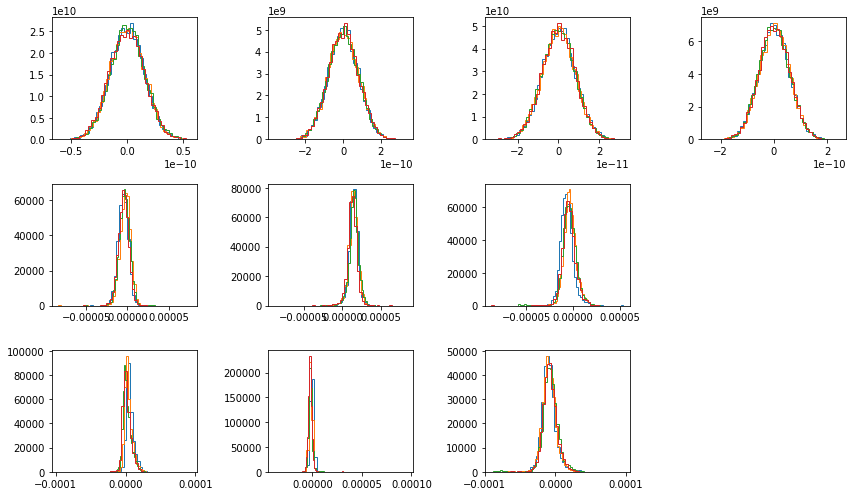

In [84]:
pp.figure(figsize=(12,7))

for i in range(10):
    pp.subplot(3,4,i+2 if i > 6 else i+1)
    
    for post,color in zip([post421,post430,post435,post436],['C0','C1','C2','C3']):
        pp.hist(post[:,i],histtype='step',density=True,color=color,bins=40)
        pp.tight_layout()
    
pp.tight_layout()

In [72]:
def jpostorbs(post,step=10):
    jdpostphys = np.einsum('ij,kj->ki',cmat,post[:,4:-1])
    return csec * np.einsum('li,ijk->ljk',jdpostphys[::step,:],jjpart) # km

In [75]:
postorb421 = jpostorbs(post421)
postorb430 = jpostorbs(post430)
postorb435 = jpostorbs(post435)
postorb436 = jpostorbs(post436)

In [76]:
postorb421.shape

(972, 12986, 3)

Posteriors for all DEs seem to agree on a deviation along z/ecliptic z... furthermore, no individual DE is close enough.

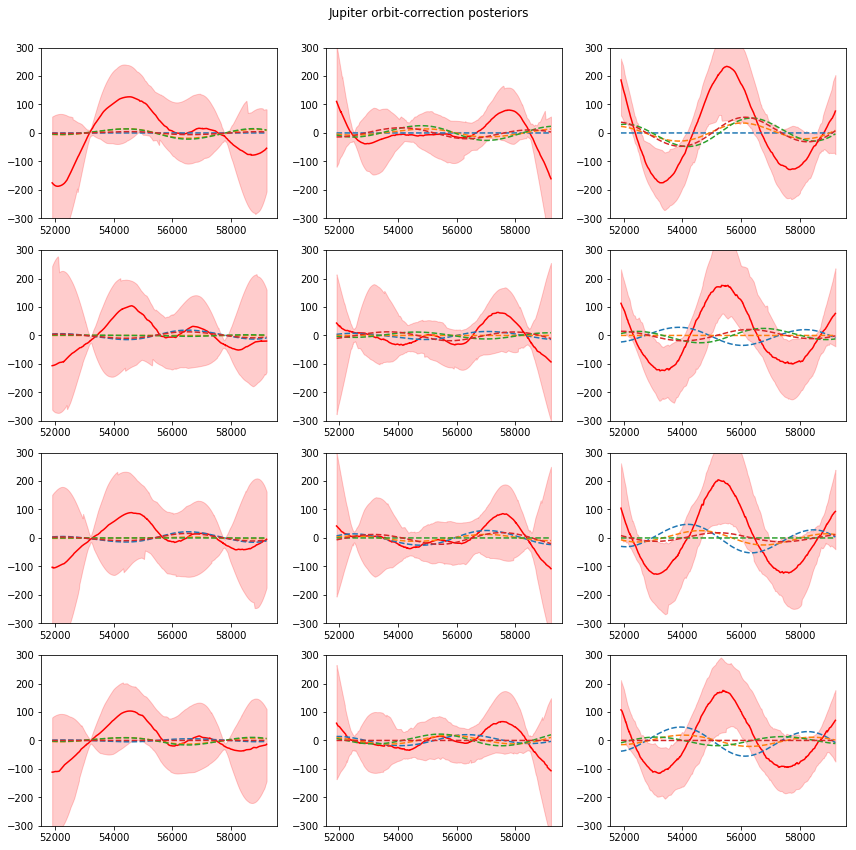

In [131]:
fig = pp.figure(figsize=(12,12))
axes = fig.subplots(4,3).flatten()

for i,(ref,orb) in enumerate(zip(['de421.bsp','de430t.bsp','de435t.bsp','de436t.bsp'],
                                 [postorb421,postorb430,postorb435,postorb436])):
    plorb(orb[::10,:,:],axes[3*i:3*(i+1)],'r',equatorial=True)
    plbsp(jd,'de421.bsp', axes[3*i:],'C0',equatorial=True,bspref=ref) # blue
    plbsp(jd,'de430t.bsp',axes[3*i:],'C1',equatorial=True,bspref=ref) # orange
    plbsp(jd,'de435t.bsp',axes[3*i:],'C2',equatorial=True,bspref=ref) # green
    plbsp(jd,'de436t.bsp',axes[3*i:],'C3',equatorial=True,bspref=ref) # red

for ax in axes:
    ax.set_ylim([-300,300])
    
pp.suptitle('Jupiter orbit-correction posteriors');
pp.tight_layout(rect=[0,0,1,0.95])

pp.savefig('mcmc-posteriors-20180414/compare-posteriors.png')

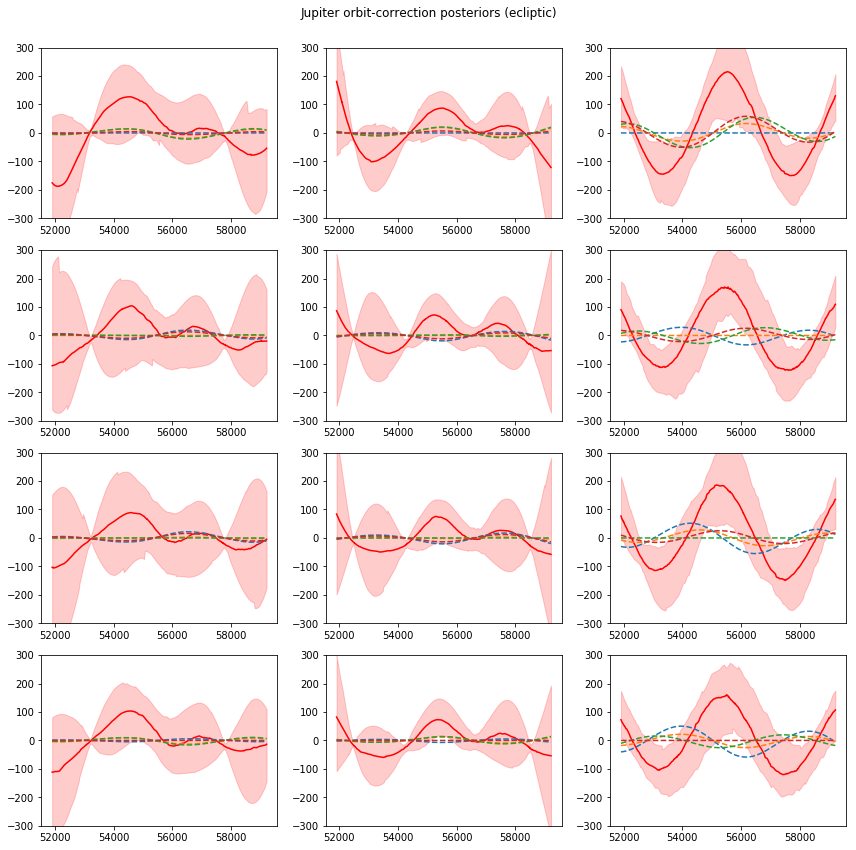

In [130]:
fig = pp.figure(figsize=(12,12))
axes = fig.subplots(4,3).flatten()

for i,(ref,orb) in enumerate(zip(['de421.bsp','de430t.bsp','de435t.bsp','de436t.bsp'],
                                 [postorb421,postorb430,postorb435,postorb436])):
    plorb(orb[::10,:,:],axes[3*i:3*(i+1)],'r',equatorial=False)
    plbsp(jd,'de421.bsp', axes[3*i:],'C0',equatorial=False,bspref=ref)
    plbsp(jd,'de430t.bsp',axes[3*i:],'C1',equatorial=False,bspref=ref)
    plbsp(jd,'de435t.bsp',axes[3*i:],'C2',equatorial=False,bspref=ref)
    plbsp(jd,'de436t.bsp',axes[3*i:],'C3',equatorial=False,bspref=ref)

for ax in axes:
    ax.set_ylim([-300,300])
    
pp.suptitle('Jupiter orbit-correction posteriors (ecliptic)');
pp.tight_layout(rect=[0,0,1,0.95])

pp.savefig('mcmc-posteriors-20180414/compare-posteriors-ecliptic.png')

See if the posteriors change by restricting to small mass perturbations. (They don't, but it was an interesting idea.)

In [163]:
postorb436c = jpostorbs(post436[np.abs(post436[:,0]) < 0.2e-12],step=1)

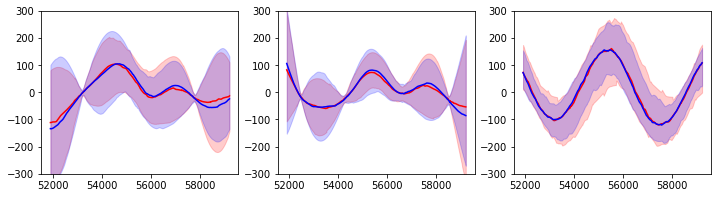

In [164]:
fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3).flatten()

plorb(postorb436[::10,:,:],axes,'r',equatorial=False)
plorb(postorb436c[::1,:,:],axes,'b',equatorial=False)

for ax in axes:
    ax.set_ylim([-300,300])

Plot posteriors together with respect to DE436.

In [197]:
def plorbref(array,axes,color,bsp='de436t.bsp',bspref='de436t.bsp',median=True,equatorial=True):
    p, v = getplanet(5, jd, bsp=bsp)
    pref, vref = getplanet(5, jd, bsp=bspref)

    array = array.copy()
    array += (p - pref)
    
    if not equatorial: array = eq2ecl_tens(array)
    
    for obs in range(3):
        axes[obs].plot(mjd,np.percentile(array,5,axis=0)[:,obs],color + '--')
        axes[obs].plot(mjd,np.percentile(array,95,axis=0)[:,obs],color + '--')
        axes[obs].plot(mjd,np.median(array,axis=0)[:,obs],color,label=bsp.split('.')[0])

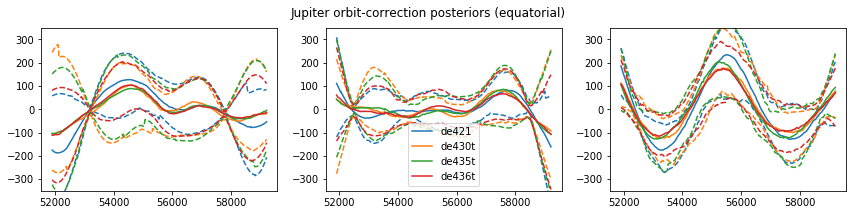

In [198]:
fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3).flatten()

#                                 blue        orange       green        red
for i,(bsp,orb) in enumerate(zip(['de421.bsp','de430t.bsp','de435t.bsp','de436t.bsp'],
                                 [postorb421,postorb430,postorb435,postorb436])):
    plorbref(orb[::10,:,:],axes,bsp=bsp,color='C{}'.format(i),equatorial=True)

for ax in axes:
    ax.set_ylim([-350,350])
    
axes[1].legend(loc=8)
    
pp.suptitle('Jupiter orbit-correction posteriors (equatorial)')
pp.tight_layout(rect=[0,0,1,0.95])

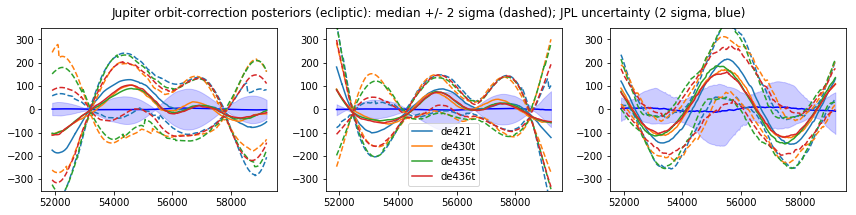

In [221]:
fig = pp.figure(figsize=(12,3))
axes = fig.subplots(1,3).flatten()

plorb(2*arandx,axes,color='b',median=False,equatorial=False)

#                                 blue        orange       green        red
for i,(bsp,orb) in enumerate(zip(['de421.bsp','de430t.bsp','de435t.bsp','de436t.bsp'],
                                 [postorb421,postorb430,postorb435,postorb436])):
    plorbref(orb[::10,:,:],axes,bsp=bsp,color='C{}'.format(i),equatorial=False)

for ax in axes:
    ax.set_ylim([-350,350])
    
axes[1].legend(loc=8)
    
pp.suptitle('Jupiter orbit-correction posteriors (ecliptic): median +/- 2 sigma (dashed); JPL uncertainty (2 sigma, blue)');
pp.tight_layout(rect=[0,0,1,0.95])

pp.savefig('mcmc-posteriors-20180414/all-corrections.png')

### Compare physical posteriors for Jupiter with older Keplerian posteriors

In [50]:
keplerian_post = np.load('mcmc-posteriors-20180504/bayes_ephem_posteriors.npz')

Jupiter partials are columns 74 to 79; frame drift is 69, JSUN masses 70-73.

In [54]:
keplerian_post['chain_de436_noprior'].shape

(204700, 84)

In [59]:
ls bayes_ephem_project/data/jupiter_orbitpartials

jupiter-orbel-mjd.npy      jupiter-orbel-xyz.npy
jupiter-orbel-xyz-svd.npy


In [93]:
keplerian_mjd = np.load('bayes_ephem_project/data/jupiter_orbitpartials/jupiter-orbel-mjd.npy')

In [60]:
keplerian_basis = np.load('bayes_ephem_project/data/jupiter_orbitpartials/jupiter-orbel-xyz-svd.npy')

In [64]:
keplerian_basis.shape

(6, 2000, 3)

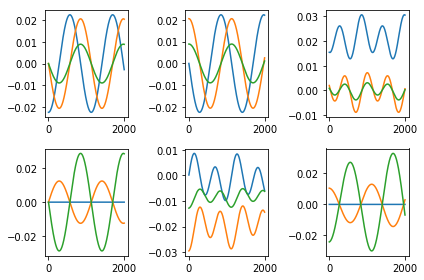

In [63]:
for i in range(6):
    pp.subplot(2,3,i+1)

    for j in range(3):
        pp.plot(keplerian_basis[i,:,j])
        
    pp.tight_layout()

Take a minus since the Keplerian elements were applied without it...

For physical (Sun) partials:

$\Delta(x_\mathrm{E} - x_\mathrm{SSB}) = \Delta(x_\mathrm{E} - x_\mathrm{Sun}) + \Delta(x_\mathrm{Sun} - x_\mathrm{SSB}) = 0 + \Delta x_\mathrm{Sun}$

For Keplerian (Jupiter) partials:

$\Delta(x_\mathrm{E} - x_\mathrm{SSB}) = \Delta(x_\mathrm{E} - x_\mathrm{Sun}) + \Delta(x_\mathrm{Sun} - x_\mathrm{SSB}) = 0 - \Delta x_\mathrm{SSB} =
0 - \frac{M_\mathrm{Jup}}{M_\mathrm{tot}} \Delta x_\mathrm{Jup}$

In [104]:
keplerian_mean = -np.einsum('ij,jkl->kl',
                            keplerian_post['chain_de436_noprior'][::100,74:80],
                            keplerian_basis) / \
                 keplerian_post['chain_de436_noprior'][::100,:].shape[0]

In [122]:
keplerian_mean435 = -np.einsum('ij,jkl->kl',
                               keplerian_post['chain_de435_noprior'][::100,74:80],
                               keplerian_basis) / \
                    keplerian_post['chain_de435_noprior'][::100,:].shape[0]

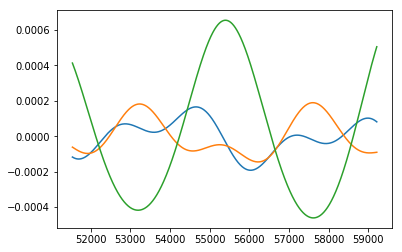

In [105]:
for j in range(3):
    pp.plot(keplerian_mjd,
            project(keplerian_mjd,keplerian_mean[:,j],degree=1)[2])

In [80]:
meanorb436 = np.mean(postorb436,axis=0)

In [123]:
meanorb435 = np.mean(postorb435,axis=0)

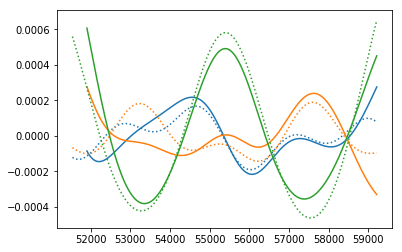

In [121]:
for j in range(3):
    pp.plot(mjd,
            project(mjd,meanorb436[:,j],degree=2)[2]/csec,
            'C' + '012'[j])
    pp.plot(keplerian_mjd,
            project(keplerian_mjd,keplerian_mean[:,j],degree=2)[2],
            ':C' + '012'[j])

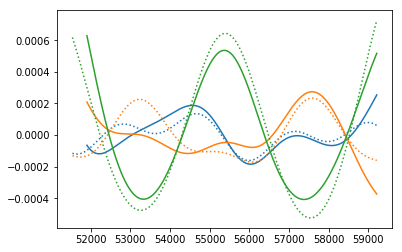

In [124]:
for j in range(3):
    pp.plot(mjd,
            project(mjd,meanorb435[:,j],degree=2)[2]/csec,
            'C' + '012'[j])
    pp.plot(keplerian_mjd,
            project(keplerian_mjd,keplerian_mean435[:,j],degree=2)[2],
            ':C' + '012'[j])

## Older tests

In [819]:
j1, vj1 = getplanet(5,jdates)
j2, vj2 = getplanet(5,jdates,bsp=bsp2)

dd = np.zeros(6*9,'d')

# dd[5*6:5*6+1] = j2[0,:1]-j1[0,:1]

dd[5*6:5*6+3] = j2[0,:]-j1[0,:]
dd[5*6+3:5*6+6] = vj2[0,:]-vj1[0,:]

csol2b = cintegrate(y0+dd,masses)

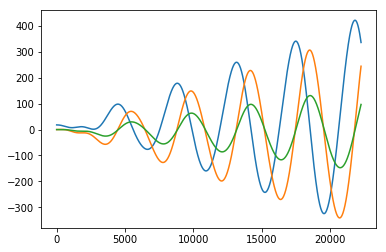

In [821]:
# change only x...

for i in range(3):
    pp.plot(t(csol2b) / 86400,
            csec*(sin.interp1d(t(csol),sel(csol,5)[:,i],kind='cubic')(t(csol2b)) - sel(csol2b,5)[:,i]))

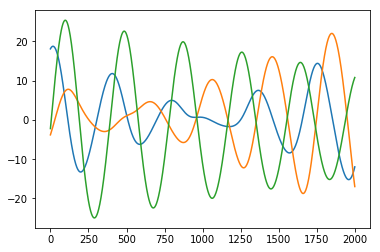

In [806]:
for i in range(3):
    pp.plot(csec*(j1[:,i] - j2[:,i]))

# pp.axis(xmin=950,xmax=970,ymin=-5,ymax=5)

Make a norm out of orbit differences, sample initial conditions to stay within.

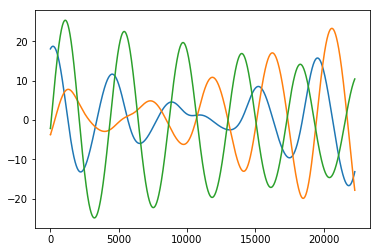

In [814]:
for i in range(3):
    pp.plot(t(csol2b) / 86400,
            csec*(sin.interp1d(t(csol),sel(csol,5)[:,i],kind='cubic')(t(csol2b)) - sel(csol2b,5)[:,i]))

Next, try individual pos/vel variables, with scale given by difference between DE436 and DE435

In [786]:
# pos/vel perturbation

def dp(i,j,d):
    ret = np.zeros(6*9,'d')
    ret[i*6+j] = d
    return ret

In [785]:
j1, vj1 = getplanet(5,jdates)
j2, vj2 = getplanet(5,jdates,bsp=bsp2)

dpos = []
dvel = []

for p in range(9):
    j1, vj1 = getplanet(10 if p == 0 else p,jdates)
    j2, vj2 = getplanet(10 if p == 0 else p,jdates,bsp=bsp2)
    
    # take differences at beginning
    dpos.append(max(abs(j1[0,i]-j2[0,i]) for i in range(3)))
    dvel.append(max(abs(vj1[0,i]-vj2[0,i]) for i in range(3)))

    # dpos.append(max(np.max(np.abs(j1[:,i]-j2[:,i])) for i in range(3)))
    # dvel.append(max(np.max(np.abs(vj1[:,i]-vj2[:,i])) for i in range(3)))

In [787]:
csol2 = [
    cintegrate(y0 + dp(5,0,dpos[5]),masses),
    cintegrate(y0 + dp(5,1,dpos[5]),masses),
    cintegrate(y0 + dp(5,2,dpos[5]),masses),
    cintegrate(y0 + dp(5,3,dvel[5]),masses),
    cintegrate(y0 + dp(5,4,dvel[5]),masses),
    cintegrate(y0 + dp(5,5,dvel[5]),masses)
]

Deviations in Jupiter's orbit with DE435/DE436 difference (km). Works out to 2000 km?

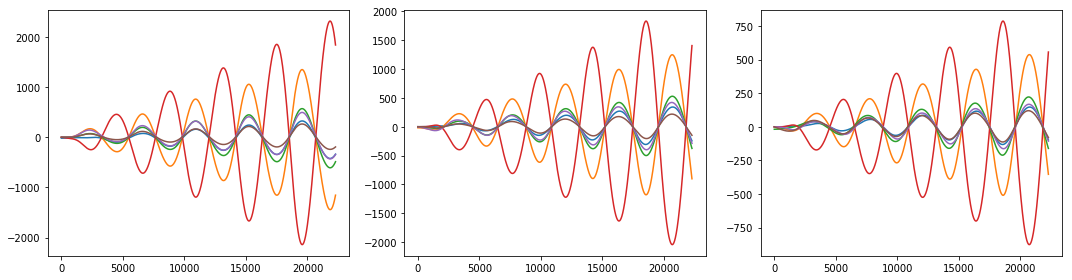

In [815]:
pp.figure(figsize=(15,4))

for i in range(3):
    pp.subplot(1,3,i+1)
    for j in range(6):
        pp.plot(t(csol2[j]) / 86400,
                csec*(sin.interp1d(t(csol),sel(csol,5)[:,i],kind='cubic')(t(csol2[j])) - sel(csol2[j],5)[:,i]))
        
pp.tight_layout()

Compare the nonlinear and linear effect on the Sun.

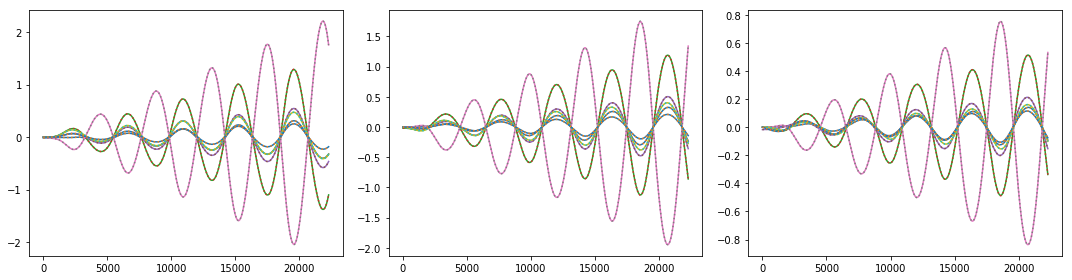

In [816]:
pp.figure(figsize=(15,4))

for i in range(3):
    pp.subplot(1,3,i+1)
    for j in range(6):
        pp.plot(t(csol2[j]) / 86400,
            masses[5]/sum(masses)*csec*(sin.interp1d(t(csol),sel(csol,5)[:,i],kind='cubic')(t(csol2[j])) - sel(csol2[j],5)[:,i]))
        
        pp.plot(t(csol2[j]) / 86400,
            -csec*(sin.interp1d(t(csol),sel(csol,0)[:,i],kind='cubic')(t(csol2[j])) - sel(csol2[j],0)[:,i]),':')
        
pp.tight_layout()

These are accurate at subpercent level.

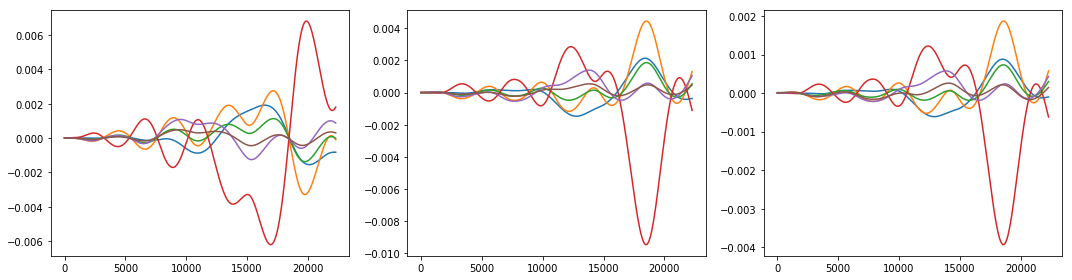

In [817]:
pp.figure(figsize=(15,4))

for i in range(3):
    pp.subplot(1,3,i+1)
    for j in range(6):
        pp.plot(t(csol2[j]) / 86400,
            masses[5]/sum(masses)*csec*(sin.interp1d(t(csol),sel(csol,5)[:,i],kind='cubic')(t(csol2[j])) - sel(csol2[j],5)[:,i])
               
            +csec*(sin.interp1d(t(csol),sel(csol,0)[:,i],kind='cubic')(t(csol2[j])) - sel(csol2[j],0)[:,i]))
        
pp.tight_layout()